# Postmating response in _Ae. aegypti_ female reproductive tract after artifical MAG injection

Load packages:

In [1]:
## Packages to load
req_packages = c("AnnotationHub", "Biobase", "cluster", "clusterProfiler", "cowplot", "cummeRbund", 
                 "data.table", "EDASeq", "edgeR", "gage", "ggpubr", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", "lattice", 
                 "imager", "pheatmap", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "RUVSeq","splitstackshape", "statmod", "stringr", "tidyverse",
                 "VennDiagram", "viridis")
## load them, quietly
invisible(suppressWarnings(suppressMessages(
    lapply(req_packages, require, character.only = TRUE)
)))

## The Cowplot package changes the default themes of ggplot2. Set the bw theme with larger font sizes like so:
theme_set(theme_bw(base_size = 16))
## ... or set the default theme
# theme_set(theme_gray())

## suppress excessive VennDiagram log files
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")

## custom functions:
source("Functions.R")

NULL

Load count files (ballgown and qualiMap), and create study subsets:

In [2]:
counts_qM = read.csv("Default_mapping_protocol/ballgown/qM_gene_counts.txt", header=T, row.names=1, sep='\t', check.names = T)
colnames(counts_qM) = gsub("Albo", "Al", colnames(counts_qM))
counts_qM = subset(counts_qM, !is.na(Ae1_M24))
counts_qM <- counts_qM[ order(row.names(counts_qM)), ]
counts_qM_Alfonso = select(counts_qM, -contains("A"))
counts_qM_Amaro = select(counts_qM, contains("A"))
# remove bad replicate from count matrix:
counts_qM_Amaro = select(counts_qM_Amaro, -contains(c("Ae2_Non")))

counts_hs2 = read.csv("Default_mapping_protocol/ballgown/gene_counts.csv", header=T, row.names=1, sep=',', check.names = T)
colnames(counts_hs2) = gsub("Albo", "Al", colnames(counts_hs2))
counts_hs2_Alfonso = select(counts_hs2, -contains("A"))
counts_hs2_Amaro = select(counts_hs2, contains("A"))
# remove bad replicate from count matrix:
counts_hs2_Amaro = select(counts_hs2_Amaro, -contains("Ae2_Non"))

Load the Trinotate and VectorBase annotation files from the ejaculotome project:

In [3]:
trinotate = read.csv("Misc/Trinotate_report.xls_with_description_columns.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
AaegL5_annotation = read.csv("Misc/AaegL5.gene.annotation.txt", header = T, sep = "\t")
annTrin = unique(select(trinotate, gene_id, sprot_Top_BLASTX_hit_description))
Annots = merge(AaegL5_annotation, annTrin, by.x = "gene_id", by.y = "gene_id", all = T)

Load GO analysis info:

In [4]:
GO_info = read.csv("Annotations/Trinotate_report.xls.gene_ontology", header=F, row.names=1, sep = "\t", stringsAsFactors=F)

Load DE genes from Alfonso _et al._ (2016)

In [36]:
DE_genes_2016 = read.csv("Misc/DE_genes_2016.txt", header = T, sep = "\t")
DE_genes_2016_subset <- select(DE_genes_2016, Gene_ID_2016 = Gene_ID , cluster_2016 = Merged.Cluster, annotation_2016 = VectorBase.Description...Blastx_hit..n.s..blast.hit., RPKM_virgin = virgin, RPKM_0hpm = X0hpm, RPKM_6hpm = X6hpm, RPKM_24hpm = X24hpm)

Check the library sizes:

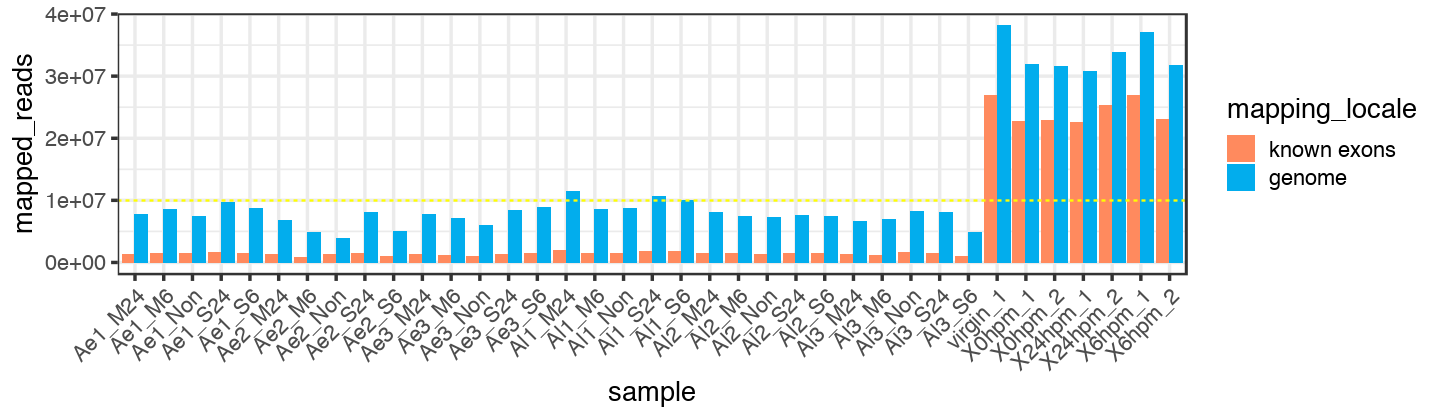

In [5]:
a.bt2LibSizes <- as.data.frame(colSums(counts_qM))
pasa.LibSizes <- as.data.frame(colSums(counts_hs2))
libSizes = cbind(a.bt2LibSizes, pasa.LibSizes)
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "known exons", "genome")
libSizes = melt(libSizes, id.vars = "sample")
colnames(libSizes) = c("sample", "mapping_locale", "mapped_reads")

options(repr.plot.width = 12, repr.plot.height = 3.5)
# pdf("Figures/Library_sizes.pdf", width = 12, height = 4)
ggplot(libSizes, aes(sample, mapped_reads, fill = mapping_locale)) + 
    geom_bar(stat="identity", position = "dodge") + 
#     theme_monokai_full() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) + 
    geom_hline(yintercept = 10000000, colour = "yellow", linetype= "dashed") +
    scale_fill_manual(values = c("#ff8a5e","#02aded"))
# dev.off()

Create a sample description object:

In [6]:
sample.info = read.table("samples.txt", header = F, check.names = F, fill = T)
colnames(sample.info) = c("sample", "replicate")
sample.info$study = ifelse(grepl("A", sample.info$sample), "Amaro", "Alfonso-Para")

Split the sample info into two parts representing the two studies:

In [7]:
sample.info_Alfonso = subset(sample.info, study == "Alfonso-Para")
sample.info_Alfonso$sample = ifelse(sample.info_Alfonso$sample != "virgin", gsub("^", "X", sample.info_Alfonso$sample), "virgin")
sample.info_Alfonso$status = ifelse(sample.info_Alfonso$sample == "virgin", "virgin", "mated")

sample.info_Amaro = subset(sample.info, study == "Amaro")
sample.info_Amaro$treatment = ifelse(grepl("M", sample.info_Amaro$sample), "MAG", ifelse(grepl("Non", sample.info_Amaro$sample), "none", "Saline"))
sample.info_Amaro$source = ifelse(grepl("Ae", sample.info_Amaro$sample), "aegypti", "albopictus")
sample.info_Amaro$timepoint = ifelse(grepl("6", sample.info_Amaro$sample), "6hpi", ifelse(grepl("24", sample.info_Amaro$sample), "24hpi", "not inj."))
## remove the bad replicate:
sample.info_Amaro = subset(sample.info_Amaro, replicate != "Ae2_Non")

Make TPM matrices from the count data. For the Amaro dataset this is straight forward since gene lengths don't matter: 

In [8]:
Amaro.geneTPM.matrix<- apply(counts_qM_Amaro, 2, function(x) tpm(x, 2922))
Amaro.geneTPM.matrix = as.data.frame(Amaro.geneTPM.matrix)

Make a TPM table for individual gene plotting and heatmaps:

In [9]:
tmp.tpmMatrix<-Amaro.geneTPM.matrix
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
Amaro.geneTPM.table <- merge(sample.info_Amaro, tmp.tpmMatrix.m, by.x = "replicate", by.y = "replicate", all.y = T)
rm(tmp.tpmMatrix, tmp.tpmMatrix.m)

For the Alfonso dataset we need to extract the gene lengths:

In [10]:
# Load transcript lengths:
VB_trans_lengths = read.csv("Misc/AaegL5_VB.gtf_transcript_lengths.txt", header = F, sep = " ")
# select transcrip IDs column and length column only:
tmp.df = select(VB_trans_lengths, V1, V2)
tmp.df$V1 = gsub("-R.*", "", tmp.df$V1)
colnames(tmp.df) = c("gene_id", "length")
# For each gene ID entry, select the entry with largest value in the "length" column:
VB_gene_lengths = aggregate(length ~ gene_id, tmp.df, max)
# assign gene names to rownames
rownames(VB_gene_lengths) <- VB_gene_lengths$gene_id
# # select the length column only
VB_gene_lengths = subset(VB_gene_lengths, select = "length")
# remove un-needed intermediate objects
rm(tmp.df)

Extract relevant GO terms:

In [11]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = VB_gene_lengths[features_with_GO,]

Calculate TPM values:

In [12]:
Alfonso.geneTPM.matrix<- apply(counts_qM_Alfonso, 2, function(x) tpm(x, VB_gene_lengths$length))
Alfonso.geneTPM.matrix = as.data.frame(Alfonso.geneTPM.matrix)

Make the TPM table:

In [13]:
tmp.tpmMatrix<-Alfonso.geneTPM.matrix
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
tmp.tpmMatrix.m$replicate <- gsub("^X", "", tmp.tpmMatrix.m$replicate)
Alfonso.geneTPM.table <- merge(sample.info_Alfonso, tmp.tpmMatrix.m, by.x = "replicate", by.y = "replicate", all.y = T)
Alfonso.geneTPM.table$sample <- gsub("^X", "", Alfonso.geneTPM.table$sample)
rm(tmp.tpmMatrix, tmp.tpmMatrix.m)

A plotting function for this dataset works as follows:

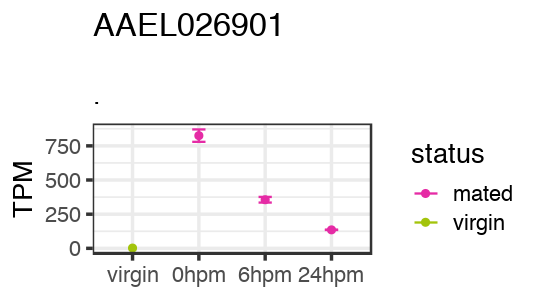

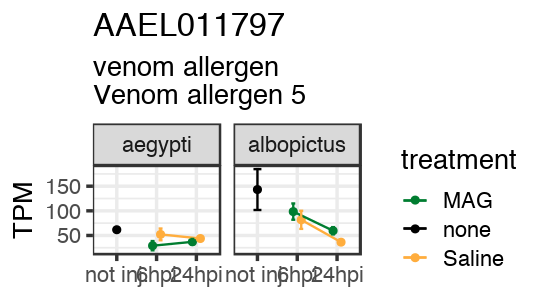

In [14]:
options(repr.plot.width = 4.5, repr.plot.height = 2.5)
suppressWarnings(genePointPlot_Alfonso("AAEL026901", show_reps = F))
genePointPlot_Amaro(tpmTable = Amaro.geneTPM.table, gene = "AAEL011797")

## Original study (Alfonso-Para and Ahmed-Braimah _et. al._ 2016) 

#### QualiMap annotated count data

In [15]:
cpm_qM_Alfonso <- cpm(counts_qM_Alfonso)
thresh_qM_Alfonso <- cpm_qM_Alfonso > 5
keep_qM_Alfonso <- rowSums(thresh_qM_Alfonso) >= 2
countsKeep_qM_Alfonso <- counts_qM_Alfonso[keep_qM_Alfonso,]
# countsKeep_qM <- subset(countsKeep_qM, rownames(countsKeep_qM) %!in% wierd_genes)
table(keep_qM_Alfonso)

keep_qM_Alfonso
FALSE  TRUE 
11530  8182 

Define groups for differential expression:

In [16]:
groups_Alfonso = factor(sample.info_Alfonso$sample)
design_Alfonso = model.matrix(~0+groups_Alfonso)
colnames(design_Alfonso) <- levels(groups_Alfonso)
rownames(design_Alfonso) <- sample.info_Alfonso$replicate

Fit the DGE model:

In [17]:
dgeList_Alfonso <- DGEList(counts = countsKeep_qM_Alfonso, group = groups_Alfonso)
dgeList_Alfonso <- calcNormFactors(dgeList_Alfonso)
dgeList_Alfonso <- estimateDisp(dgeList_Alfonso, design_Alfonso)
# dgeList <- estimateGLMTagwiseDisp(dgeList, design)
dgeList_Alfonso_fit <- glmQLFit(dgeList_Alfonso, design_Alfonso)
summary(dgeList_Alfonso$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.005864 0.009622 0.014034 0.023844 0.023295 0.777509 

Check some of the model fitting parameters:

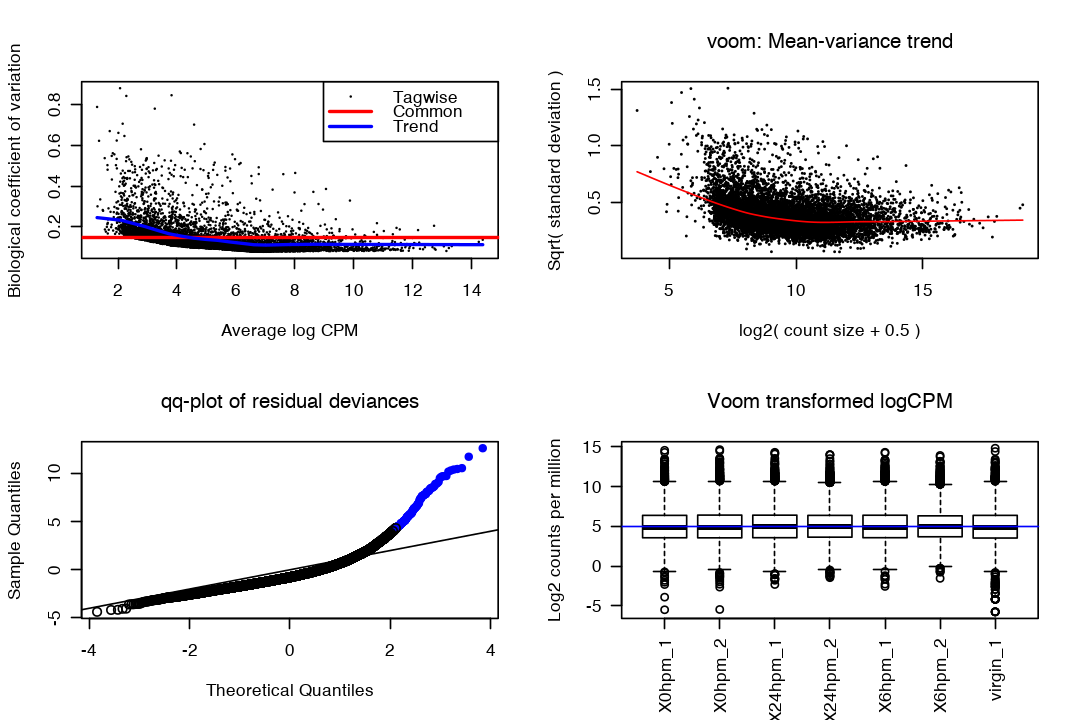

In [18]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList_Alfonso)
# mean-variance trend
voom = voom(dgeList_Alfonso, design_Alfonso, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_Alfonso_fit, plot = T, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom)

Check the sample grouping:

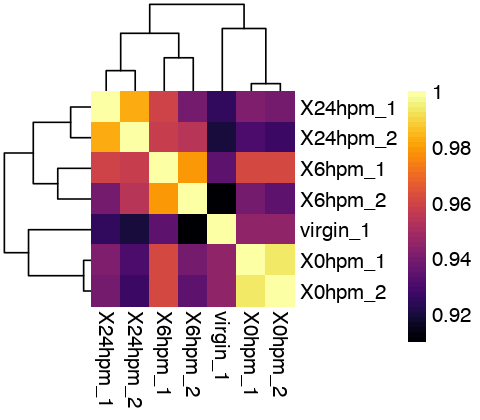

In [19]:
## Plot sample correlation
data = log2(countsKeep_qM_Alfonso+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')

options(repr.plot.width = 4, repr.plot.height = 3.5)
pheatmap(
  mat               = sample_cor,
  color             = inferno(50),
  border_color      = NA,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
#   filename          = "Figures/sample_correlations_all.pdf",
#   width             = 6, 
#   height            = 5,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

Also check the MDS plot:

In [20]:
glMDSPlot(dgeList_Alfonso, groups = dgeList_Alfonso$samples$group, labels = sample.info_Alfonso$V2, html = T)

Add annotation info to DGEList object:

In [21]:
# Extract annotation for genes in the fit object
ann = subset(Annots, gene_id %in% rownames(dgeList_Alfonso_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_Alfonso_fit), ann$gene_id),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "gene_name", "VectorBae_description", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_Alfonso_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_Alfonso_fit$genes = ann
rm(ann)


TRUE 
8182 

Now define the relevant contrasts, for example between the 6hpm timepoint and virgin:

In [22]:
hpm0.v.virgin <- makeContrasts(X0hpm-virgin,
                          levels=design_Alfonso)

Ftest.hpm0.v.virgin <- glmQLFTest(dgeList_Alfonso_fit, contrast = hpm0.v.virgin)
Ftest.hpm0.v.virgin.tTags <- topTags(Ftest.hpm0.v.virgin, n = NULL)
Ftest.hpm0.v.virgin.tTags.table <- Ftest.hpm0.v.virgin.tTags$table
Ftest.hpm0.v.virgin.tTags.table$sig = ifelse(Ftest.hpm0.v.virgin.tTags.table$FDR < 0.05 & (Ftest.hpm0.v.virgin.tTags.table$logFC > 1 | Ftest.hpm0.v.virgin.tTags.table$logFC < -1), "yes", "no")
Ftest.hpm0.v.virgin.tTags.table$direction = ifelse(Ftest.hpm0.v.virgin.tTags.table$sig == "yes" & Ftest.hpm0.v.virgin.tTags.table$logFC > 1, "upregulated", ifelse(Ftest.hpm0.v.virgin.tTags.table$sig == "yes" & Ftest.hpm0.v.virgin.tTags.table$logFC < -1, "downregulated", "."))
Alfonso_0hpm_v_virgin_sigGene_up <- rownames(subset(Ftest.hpm0.v.virgin.tTags.table, direction == "upregulated"))
Alfonso_0hpm_v_virgin_sigGene_down <- rownames(subset(Ftest.hpm0.v.virgin.tTags.table, direction == "downregulated"))
paste(length(Alfonso_0hpm_v_virgin_sigGene_up), " genes are upregulated at 0 hpm, and ", length(Alfonso_0hpm_v_virgin_sigGene_down), " are downregulated." ,sep = "")
head(Ftest.hpm0.v.virgin.tTags.table)

write.table(filter(Ftest.hpm0.v.virgin.tTags.table, sig == "yes"), "Results/Tables/Alfonso_data_reanalysis/DE_significant_genes_0hpm.txt", quote = F, row.names = F, sep = "\t")

[1] "58 genes are upregulated at 0 hpm, and 6 are downregulated."

,GeneID,gene_name,VectorBae_description,SwissProt_BlastX_Description,logFC,logCPM,F,PValue,FDR,sig,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
AAEL026901,AAEL026901,NA,NA,.,8.728665,6.173006,1430.3099,1.993677e-08,0.0001194987,yes,upregulated
AAEL025598,AAEL025598,NA,NA,.,10.032933,6.872381,1099.7750,4.404531e-08,0.0001194987,yes,upregulated
AAEL025144,AAEL025144,NA,NA,.,11.165065,4.978494,1077.0372,4.690836e-08,0.0001194987,yes,upregulated
AAEL020035,AAEL020035,NA,NA,.,9.283582,12.105557,1001.3929,5.842028e-08,0.0001194987,yes,upregulated
AAEL024630,AAEL024630,NA,NA,Head peptide,8.153362,7.551318,630.5690,2.349441e-07,0.0003844625,yes,upregulated
AAEL020977,AAEL020977,NA,NA,.,9.348141,7.510756,579.4943,3.027734e-07,0.0004128819,yes,upregulated


In [40]:
hpm6.v.virgin <- makeContrasts(X6hpm-virgin,
                          levels=design_Alfonso)

Ftest.hpm6.v.virgin <- glmQLFTest(dgeList_Alfonso_fit, contrast = hpm6.v.virgin)
Ftest.hpm6.v.virgin.tTags <- topTags(Ftest.hpm6.v.virgin, n = NULL)
Ftest.hpm6.v.virgin.tTags.table <- Ftest.hpm6.v.virgin.tTags$table
Ftest.hpm6.v.virgin.tTags.table$sig = ifelse(Ftest.hpm6.v.virgin.tTags.table$FDR < 0.01 & (Ftest.hpm6.v.virgin.tTags.table$logFC > 1 | Ftest.hpm6.v.virgin.tTags.table$logFC < -1), "yes", "no")
Ftest.hpm6.v.virgin.tTags.table$direction = ifelse(Ftest.hpm6.v.virgin.tTags.table$sig == "yes" & Ftest.hpm6.v.virgin.tTags.table$logFC > 1, "upregulated", ifelse(Ftest.hpm6.v.virgin.tTags.table$sig == "yes" & Ftest.hpm6.v.virgin.tTags.table$logFC < -1, "downregulated", "."))
Alfonso_6hpm_v_virgin_sigGene_up <- rownames(subset(Ftest.hpm6.v.virgin.tTags.table, direction == "upregulated"))
Alfonso_6hpm_v_virgin_sigGene_down <- rownames(subset(Ftest.hpm6.v.virgin.tTags.table, direction == "downregulated"))
paste(length(Alfonso_6hpm_v_virgin_sigGene_up), " genes are upregulated at 6 hpm, and ", length(Alfonso_6hpm_v_virgin_sigGene_down), " are downregulated." ,sep = "")
head(Ftest.hpm6.v.virgin.tTags.table)

tmp_6hpm <- filter(Ftest.hpm6.v.virgin.tTags.table, sig == "yes")
tmp_6hpm <- merge(tmp_6hpm, DE_genes_2016_subset, by.x = "GeneID", by.y = "Gene_ID_2016", all.x = T)

write.table(tmp_6hpm, "Results/Tables/Alfonso_data_reanalysis/DE_significant_genes_6hpm.txt", quote = F, row.names = F, sep = "\t")
rm(tmp_6hpm)

[1] "181 genes are upregulated at 6 hpm, and 50 are downregulated."

,GeneID,gene_name,VectorBae_description,SwissProt_BlastX_Description,logFC,logCPM,F,PValue,FDR,sig,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
AAEL005676,AAEL005676,NA,adenosine deaminase,Adenosine deaminase CECR1,4.667012,5.262397,1089.0281,4.536866e-08,0.0001706912,yes,upregulated
AAEL026901,AAEL026901,NA,NA,.,7.441509,6.173006,1078.3302,4.673902e-08,0.0001706912,yes,upregulated
AAEL025598,AAEL025598,NA,NA,.,8.963972,6.872381,896.0431,8.165501e-08,0.0001706912,yes,upregulated
AAEL020035,AAEL020035,NA,NA,.,8.455629,12.105557,889.6060,8.344716e-08,0.0001706912,yes,upregulated
AAEL004949,AAEL004949,NA,elongase%2C putative,"Elongation of very long chain fatty acids protein 4 {ECO:0000255|HAMAP-Rule:MF_03204, ECO:0000305}",3.747690,6.119577,805.9217,1.123485e-07,0.0001838471,yes,upregulated
AAEL000759,AAEL000759,NA,gamma-glutamylcysteine synthetase%2C putative,Glutamate--cysteine ligase regulatory subunit,3.157837,8.428187,694.6426,1.756570e-07,0.0002395376,yes,upregulated


In [41]:
hpm24.v.virgin <- makeContrasts(X24hpm-virgin,
                          levels=design_Alfonso)

Ftest.hpm24.v.virgin <- glmQLFTest(dgeList_Alfonso_fit, contrast = hpm24.v.virgin)
Ftest.hpm24.v.virgin.tTags <- topTags(Ftest.hpm24.v.virgin, n = NULL)
Ftest.hpm24.v.virgin.tTags.table <- Ftest.hpm24.v.virgin.tTags$table
Ftest.hpm24.v.virgin.tTags.table$sig = ifelse(Ftest.hpm24.v.virgin.tTags.table$FDR < 0.01 & (Ftest.hpm24.v.virgin.tTags.table$logFC > 1 | Ftest.hpm24.v.virgin.tTags.table$logFC < -1), "yes", "no")
Ftest.hpm24.v.virgin.tTags.table$direction = ifelse(Ftest.hpm24.v.virgin.tTags.table$sig == "yes" & Ftest.hpm24.v.virgin.tTags.table$logFC > 1, "upregulated", ifelse(Ftest.hpm24.v.virgin.tTags.table$sig == "yes" & Ftest.hpm24.v.virgin.tTags.table$logFC < -1, "downregulated", "."))
Alfonso_24hpm_v_virgin_sigGene_up <- rownames(subset(Ftest.hpm24.v.virgin.tTags.table, direction == "upregulated"))
Alfonso_24hpm_v_virgin_sigGene_down <- rownames(subset(Ftest.hpm24.v.virgin.tTags.table, direction == "downregulated"))
paste(length(Alfonso_24hpm_v_virgin_sigGene_up), " genes are upregulated at 24 hpm, and ", length(Alfonso_24hpm_v_virgin_sigGene_down), " are downregulated." ,sep = "")
head(Ftest.hpm24.v.virgin.tTags.table)

tmp_24hpm <- filter(Ftest.hpm24.v.virgin.tTags.table, sig == "yes")
tmp_24hpm <- merge(tmp_24hpm, DE_genes_2016_subset, by.x = "GeneID", by.y = "Gene_ID_2016", all.x = T)

write.table(tmp_24hpm, "Results/Tables/Alfonso_data_reanalysis/DE_significant_genes_24hpm.txt", quote = F, row.names = F, sep = "\t")
rm(tmp_24hpm)

[1] "222 genes are upregulated at 24 hpm, and 133 are downregulated."

,GeneID,gene_name,VectorBae_description,SwissProt_BlastX_Description,logFC,logCPM,F,PValue,FDR,sig,direction
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
AAEL004949,AAEL004949,NA,elongase%2C putative,"Elongation of very long chain fatty acids protein 4 {ECO:0000255|HAMAP-Rule:MF_03204, ECO:0000305}",4.317743,6.119577,1013.6064,5.632474e-08,0.0001760322,yes,upregulated
AAEL022727,AAEL022727,NA,NA,.,-3.602587,5.642617,800.7346,1.145529e-07,0.0001760322,yes,downregulated
AAEL011513,AAEL011513,NA,NA,Nose resistant to fluoxetine protein 6,-4.277236,4.457126,769.5396,1.291014e-07,0.0001760322,yes,downregulated
AAEL020035,AAEL020035,NA,NA,.,7.201800,12.105557,721.0168,1.570386e-07,0.0001760322,yes,upregulated
AAEL026901,AAEL026901,NA,NA,.,6.062336,6.173006,720.7505,1.572131e-07,0.0001760322,yes,upregulated
AAEL005676,AAEL005676,NA,adenosine deaminase,Adenosine deaminase CECR1,3.618428,5.262397,712.3824,1.628318e-07,0.0001760322,yes,upregulated


And a volcano plot:

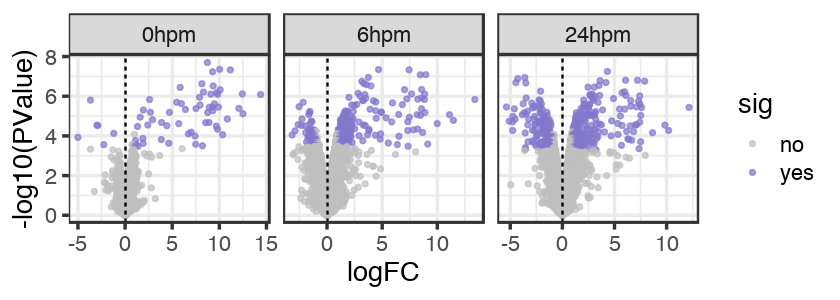

In [42]:
Ftest.hpm0.v.virgin.tTags.table$time = "0hpm"
Ftest.hpm6.v.virgin.tTags.table$time = "6hpm"
Ftest.hpm24.v.virgin.tTags.table$time = "24hpm"
Ftest.mated.v.virgin.tTags.table = rbind(Ftest.hpm0.v.virgin.tTags.table, Ftest.hpm6.v.virgin.tTags.table, Ftest.hpm24.v.virgin.tTags.table)
Ftest.mated.v.virgin.tTags.table$time = factor(Ftest.mated.v.virgin.tTags.table$time, levels = c("0hpm", "6hpm", "24hpm"))

options(repr.plot.width = 7, repr.plot.height = 2.5)
ggplot(Ftest.mated.v.virgin.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 1) + 
    facet_wrap(~time, scales = "free_x") +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#8277cc")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black")
ggsave("Results/Figures/Alfonso_data_reanalysis/DE_genes_volcanoPlot.pdf", width = 7, height = 2.5)

In [43]:
Al_DE_gene_count <- data.frame(status = c('upregualted', 'downregulated'), '0 hpm' = c(length(Alfonso_0hpm_v_virgin_sigGene_up), length(Alfonso_0hpm_v_virgin_sigGene_down)), '6 hpm' = c(length(Alfonso_6hpm_v_virgin_sigGene_up), length(Alfonso_6hpm_v_virgin_sigGene_down)), '24 hpm' = c(length(Alfonso_24hpm_v_virgin_sigGene_up), length(Alfonso_24hpm_v_virgin_sigGene_down)))
colnames(Al_DE_gene_count) = c("status", "0hpm", "6hpm", "24hpm")
Al_DE_gene_count

status,0hpm,6hpm,24hpm
<fct>,<int>,<int>,<int>
upregualted,58,181,222
downregulated,6,50,133


#### Gene Ontology:

Using the GOseq package, the GO assignment for each gene and gene lengths are required. Load GO assignments from previous pipeline:

In [44]:
GO_info = read.csv("Annotations/Trinotate_report.xls.gene_ontology", header=F, row.names=1, sep = "\t", stringsAsFactors=F)

Load the transcripts lengths, then convert to gene lengths:

In [45]:
# Load transcript lengths:
VB_trans_lengths = read.csv("Misc/AaegL5_VB.gtf_transcript_lengths.txt", header = F, sep = " ")
# select transcrip IDs column and length column only:
tmp.df = subset(VB_trans_lengths, select = c("V1", "V2"))
tmp.df$V1 = gsub("-R.*", "", tmp.df$V1)
colnames(tmp.df) = c("gene_id", "length")
# For each gene ID entry, select the entry with largest value in the "length" column:
VB_gene_lengths = aggregate(length ~ gene_id, tmp.df, max)
# assign gene names to rownames
rownames(VB_gene_lengths) <- VB_gene_lengths$gene_id
# # select the length column only
VB_gene_lengths = subset(VB_gene_lengths, select = "length")
# remove un-needed intermediate objects
rm(tmp.df)

Extract the relevant GO terms from the info fields:

In [46]:
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = VB_gene_lengths[features_with_GO,]

Here's the function to extract GO term descriptions:

In [47]:
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll run the GO analysis pipeline for each set of DE genes:

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term,time,direction
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
1073,GO:0003824,8.503368e-07,0.9999996,83,4648,catalytic activity,MF,0.01258158,MF catalytic activity,6hpm,upregualted
13691,GO:1901605,3.415511e-06,0.9999995,11,162,alpha-amino acid metabolic process,BP,0.02526795,BP alpha-amino acid metabolic process,6hpm,upregualted
3298,GO:0008236,6.963573e-06,0.9999985,16,393,serine-type peptidase activity,MF,0.02695343,MF serine-type peptidase activity,6hpm,upregualted
5273,GO:0017171,8.260431e-06,0.9999981,16,398,serine hydrolase activity,MF,0.02695343,MF serine hydrolase activity,6hpm,upregualted
1283,GO:0004252,9.108349e-06,0.9999980,15,359,serine-type endopeptidase activity,MF,0.02695343,MF serine-type endopeptidase activity,6hpm,upregualted
1273,GO:0004175,1.902124e-05,0.9999949,18,523,endopeptidase activity,MF,0.04236434,MF endopeptidase activity,6hpm,upregualted
12011,GO:0070011,2.004261e-05,0.9999939,22,718,"peptidase activity, acting on L-amino acid peptides",MF,0.04236434,"MF peptidase activity, acting on L-amino acid peptides",6hpm,upregualted


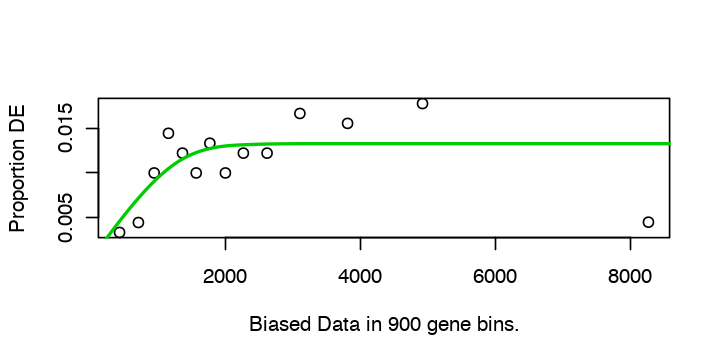

In [48]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Alfonso_6hpm_v_virgin_sigGene_up)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

cat_genes_vec = as.integer(features_with_GO %in% Alfonso_6hpm_v_virgin_sigGene_up)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
Alfonso_6hpm_up_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(Alfonso_6hpm_up_enrich_result_table$category, get_GO_term_descr))
Alfonso_6hpm_up_enrich_result_table$go_term = descr
Alfonso_6hpm_up_enrich_result_table$time = "6hpm"
Alfonso_6hpm_up_enrich_result_table$direction = "upregualted"

subset(Alfonso_6hpm_up_enrich_result_table, over_represented_FDR < 0.05)
write.table(subset(Alfonso_6hpm_up_enrich_result_table, over_represented_FDR < 0.05), "Results/Tables/Alfonso_data_reanalysis/GO_results_up_6hpm.txt", quote = F, row.names = F, sep = "\t")

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term,time,direction
<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>


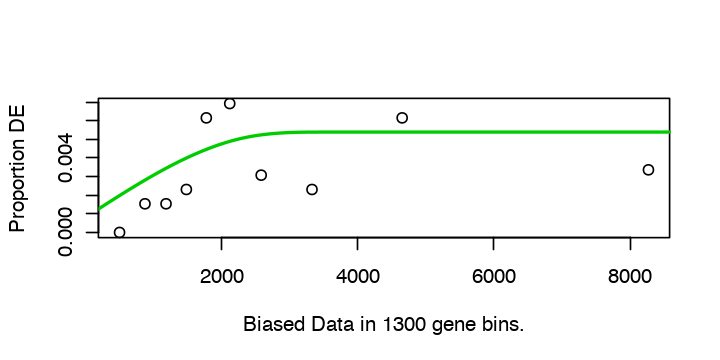

In [49]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Alfonso_6hpm_v_virgin_sigGene_down)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

cat_genes_vec = as.integer(features_with_GO %in% Alfonso_6hpm_v_virgin_sigGene_down)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
Alfonso_6hpm_down_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(Alfonso_6hpm_down_enrich_result_table$category, get_GO_term_descr))
Alfonso_6hpm_down_enrich_result_table$go_term = descr
Alfonso_6hpm_down_enrich_result_table$time = "6hpm"
Alfonso_6hpm_down_enrich_result_table$direction = "downregualted"

subset(Alfonso_6hpm_down_enrich_result_table, over_represented_FDR < 0.05)
# write.table(subset(Alfonso_6hpm_down_enrich_result_table, over_represented_FDR < 0.05), "Results/Tables/Alfonso_data_reanalysis/GO_results_down_6hpm.txt", quote = F, row.names = F, sep = "\t")

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term,time,direction
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
2431,GO:0006508,6.785681e-19,1,49,793,proteolysis,BP,1.004009e-14,BP proteolysis,24hpm,upregualted
12011,GO:0070011,8.144805e-17,1,44,718,"peptidase activity, acting on L-amino acid peptides",MF,6.025527e-13,"MF peptidase activity, acting on L-amino acid peptides",24hpm,upregualted
3295,GO:0008233,2.240499e-16,1,44,739,peptidase activity,MF,1.105014e-12,MF peptidase activity,24hpm,upregualted
1273,GO:0004175,1.125796e-15,1,36,523,endopeptidase activity,MF,4.164319e-12,MF endopeptidase activity,24hpm,upregualted
5100,GO:0016787,8.112480e-13,1,72,2153,hydrolase activity,MF,2.400645e-09,MF hydrolase activity,24hpm,upregualted
3298,GO:0008236,9.985393e-13,1,28,393,serine-type peptidase activity,MF,2.462398e-09,MF serine-type peptidase activity,24hpm,upregualted


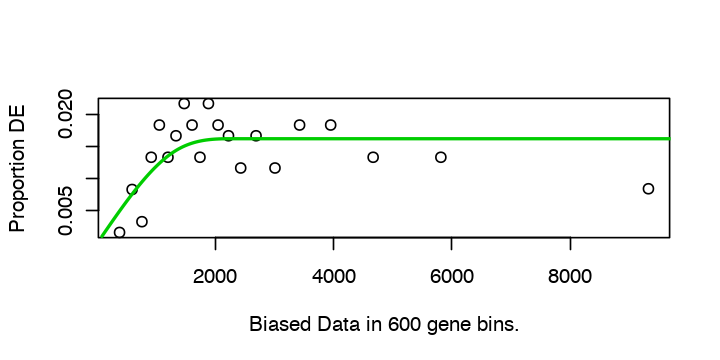

In [50]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Alfonso_24hpm_v_virgin_sigGene_up)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

cat_genes_vec = as.integer(features_with_GO %in% Alfonso_24hpm_v_virgin_sigGene_up)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
Alfonso_24hpm_up_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(Alfonso_24hpm_up_enrich_result_table$category, get_GO_term_descr))
Alfonso_24hpm_up_enrich_result_table$go_term = descr
Alfonso_24hpm_up_enrich_result_table$time = "24hpm"
Alfonso_24hpm_up_enrich_result_table$direction = "upregualted"

head(subset(Alfonso_24hpm_up_enrich_result_table, over_represented_FDR < 0.05))
write.table(subset(Alfonso_24hpm_up_enrich_result_table, over_represented_FDR < 0.05), "Results/Tables/Alfonso_data_reanalysis/GO_results_up_24hpm.txt", quote = F, row.names = F, sep = "\t")

Warning message in pcls(G):
"initial point very close to some inequality constraints"
Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term,time,direction
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
3300,GO:0008238,4.167375e-06,0.9999996,9,136,exopeptidase activity,MF,0.03415432,MF exopeptidase activity,24hpm,downregualted
1276,GO:0004180,4.616696e-06,0.9999998,6,52,carboxypeptidase activity,MF,0.03415432,MF carboxypeptidase activity,24hpm,downregualted


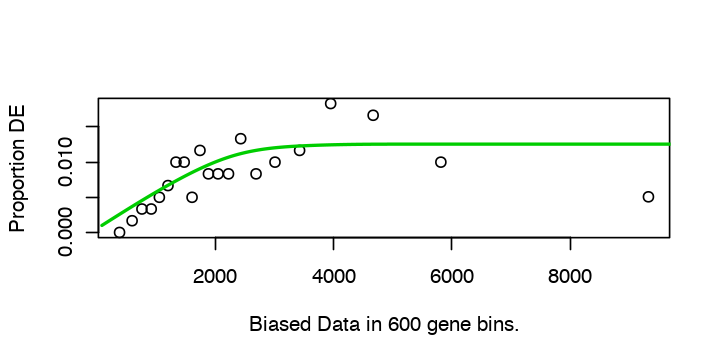

In [51]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Alfonso_24hpm_v_virgin_sigGene_down)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

cat_genes_vec = as.integer(features_with_GO %in% Alfonso_24hpm_v_virgin_sigGene_down)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
Alfonso_24hpm_down_enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(Alfonso_24hpm_down_enrich_result_table$category, get_GO_term_descr))
Alfonso_24hpm_down_enrich_result_table$go_term = descr
Alfonso_24hpm_down_enrich_result_table$time = "24hpm"
Alfonso_24hpm_down_enrich_result_table$direction = "downregualted"

subset(Alfonso_24hpm_down_enrich_result_table, over_represented_FDR < 0.05)
write.table(subset(Alfonso_24hpm_down_enrich_result_table, over_represented_FDR < 0.05), "Results/Tables/Alfonso_data_reanalysis/GO_results_down_24hpm.txt", quote = F, row.names = F, sep = "\t")

Make a summary plot of the GO results:

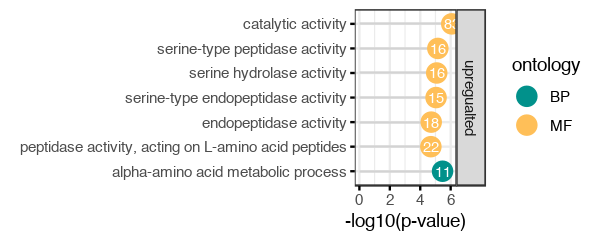

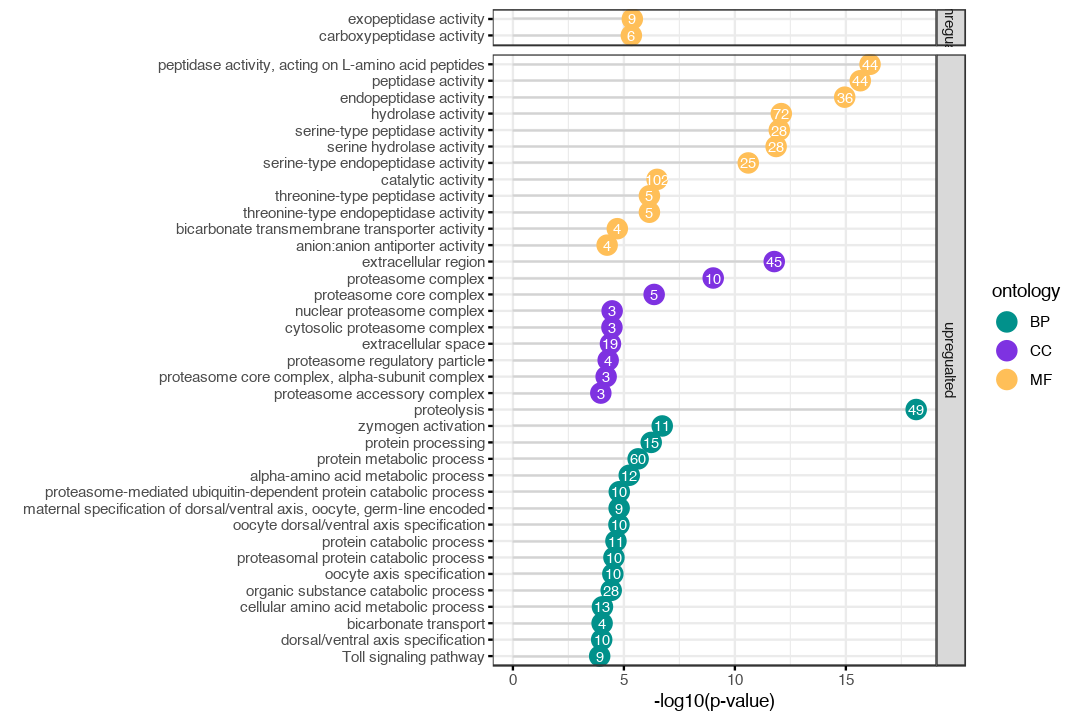

In [52]:
Al_GO_results = rbind(Alfonso_6hpm_up_enrich_result_table, Alfonso_24hpm_up_enrich_result_table, Alfonso_24hpm_down_enrich_result_table)
Al_GO_results = subset(Al_GO_results, over_represented_FDR < 0.05)
Al_GO_results$neg_log10_FDR = -log10(Al_GO_results$over_represented_pvalue)
Al_GO_results$time = factor(Al_GO_results$time, levels = c("6hpm", "24hpm"))

options(repr.plot.width = 5, repr.plot.height = 2)
ggdotchart(subset(Al_GO_results, time == "6hpm"), x = "term", y = "neg_log10_FDR",
           color = "ontology",                                # Color by groups
           palette = c("#01918b","#ffbf58"), # Custom color palette
           sorting = "descending",                       # Sort value in descending order
           add = "segments",                             # Add segments from y = 0 to dots
           rotate = TRUE,                                # Rotate vertically
           group = "ontology",                                # Order by groups
           dot.size = 5,                                 # Large dot size
           label = "numDEInCat",                        # Add mpg values as dot labels
           font.label = list(color = "white", size = 9, 
                             vjust = 0.5),               # Adjust label parameters
           ggtheme = theme_bw()                        # ggplot2 theme
           ) + labs(y = "-log10(p-value)", x = NULL) +
            facet_grid(direction~., space = "free", scales = "free")
ggsave("Results/Figures/Alfonso_data_reanalysis/postmating_GO_lollipop_6hpm.pdf", width = 9, height = 6)

options(repr.plot.width = 9, repr.plot.height = 6)
ggdotchart(subset(Al_GO_results, time == "24hpm"), x = "term", y = "neg_log10_FDR",
           color = "ontology",                                # Color by groups
           palette = c("#01918b","#7e32e1","#ffbf58"), # Custom color palette
           sorting = "descending",                       # Sort value in descending order
           add = "segments",                             # Add segments from y = 0 to dots
           rotate = TRUE,                                # Rotate vertically
           group = "ontology",                                # Order by groups
           dot.size = 5,                                 # Large dot size
           label = "numDEInCat",                        # Add mpg values as dot labels
           font.label = list(color = "white", size = 9, 
                             vjust = 0.5),               # Adjust label parameters
           ggtheme = theme_bw()                        # ggplot2 theme
           ) + labs(y = "-log10(p-value)", x = NULL) +
            facet_grid(direction~., space = "free", scales = "free")
ggsave("Results/Figures/Alfonso_data_reanalysis/postmating_GO_lollipop_24hpm.pdf", width = 9, height = 6)

## Current Study:

### Aegypti MAG injections:

Restrict the sample to the Aegypti cohort:

In [54]:
counts_qM_Amaro_Ae = select(counts_qM_Amaro, contains("Ae"))
sample.info_Amaro_Ae = filter(sample.info_Amaro, source == "aegypti")

Now filter the counts:

In [55]:
cpm_qM_Amaro_Ae <- cpm(counts_qM_Amaro_Ae)
thresh_qM_Amaro_Ae <- cpm_qM_Amaro_Ae > 5
keep_qM_Amaro_Ae <- rowSums(thresh_qM_Amaro_Ae) >= 3
countsKeep_qM_Amaro_Ae <- counts_qM_Amaro_Ae[keep_qM_Amaro_Ae,]
# countsKeep_qM <- subset(countsKeep_qM, rownames(countsKeep_qM) %!in% wierd_genes)
table(keep_qM_Amaro_Ae)

keep_qM_Amaro_Ae
FALSE  TRUE 
11934  7778 

Define groups for differential expression:

In [56]:
groups_Amaro_Ae_sample = factor(sample.info_Amaro_Ae$sample)
design_Amaro_Ae_sample = model.matrix(~0+groups_Amaro_Ae_sample)
colnames(design_Amaro_Ae_sample) <- levels(groups_Amaro_Ae_sample)
rownames(design_Amaro_Ae_sample) <- sample.info_Amaro_Ae$replicate

Adjust counts with RUVseq residuals:

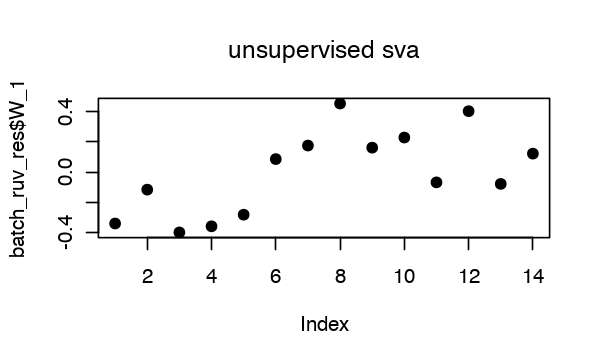

In [61]:
set <- newSeqExpressionSet(as.matrix(countsKeep_qM_Amaro_Ae), phenoData = data.frame(groups_Amaro_Ae_sample, row.names = colnames(countsKeep_qM_Amaro_Ae)))
set <- betweenLaneNormalization(set, which="upper")

y <- DGEList(counts=counts(set), group=groups_Amaro_Ae_sample)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateDisp(y, design_Amaro_Ae_sample, robust = T)
fit <- glmQLFit(y, design_Amaro_Ae_sample, dispersion = y$tagwise.dispersion, robust = T)
res <- residuals(fit, type="deviance")

batch_ruv_res = RUVr(set,rownames(countsKeep_qM_Amaro_Ae),k=3,res)
RUVrNormalizedCounts_Amaro_Ae = normCounts(object = batch_ruv_res)
rownames(RUVrNormalizedCounts_Amaro_Ae) = rownames(countsKeep_qM_Amaro_Ae)

RUVrNormalizedTPM_Amaro_Ae = tpm(counts = RUVrNormalizedCounts_Amaro_Ae, lengths = 2922)

tmp.tpmMatrix<-RUVrNormalizedTPM_Amaro_Ae
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
Amaro_Ae.geneTPM.table.rc <- merge(sample.info_Amaro_Ae, tmp.tpmMatrix.m, by.x = "replicate", by.y = "replicate", all.y = T)
rm(tmp.tpmMatrix, tmp.tpmMatrix.m)

design_2 <- model.matrix(~ 0 + groups_Amaro_Ae_sample + W_1 + W_2 + W_3, data=pData(batch_ruv_res))
colnames(design_2) <- gsub("groups_Amaro_Ae_sample", "", colnames(design_2))

options(repr.plot.width = 5, repr.plot.height = 3)
plot(batch_ruv_res$W_1,pch=19,main="unsupervised sva")

Fit the DGE model:

In [62]:
dgeList_Amaro_Ae_sample <- DGEList(counts = countsKeep_qM_Amaro_Ae, group = groups_Amaro_Ae_sample)
dgeList_Amaro_Ae_sample <- calcNormFactors(dgeList_Amaro_Ae_sample)
dgeList_Amaro_Ae_sample <- estimateDisp(dgeList_Amaro_Ae_sample, design_2)
dgeList_Amaro_Ae_sample_fit <- glmQLFit(dgeList_Amaro_Ae_sample, design_2)
summary(dgeList_Amaro_Ae_sample$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01260 0.02185 0.03381 0.04473 0.05608 0.33157 

Check some of the model fitting parameters:

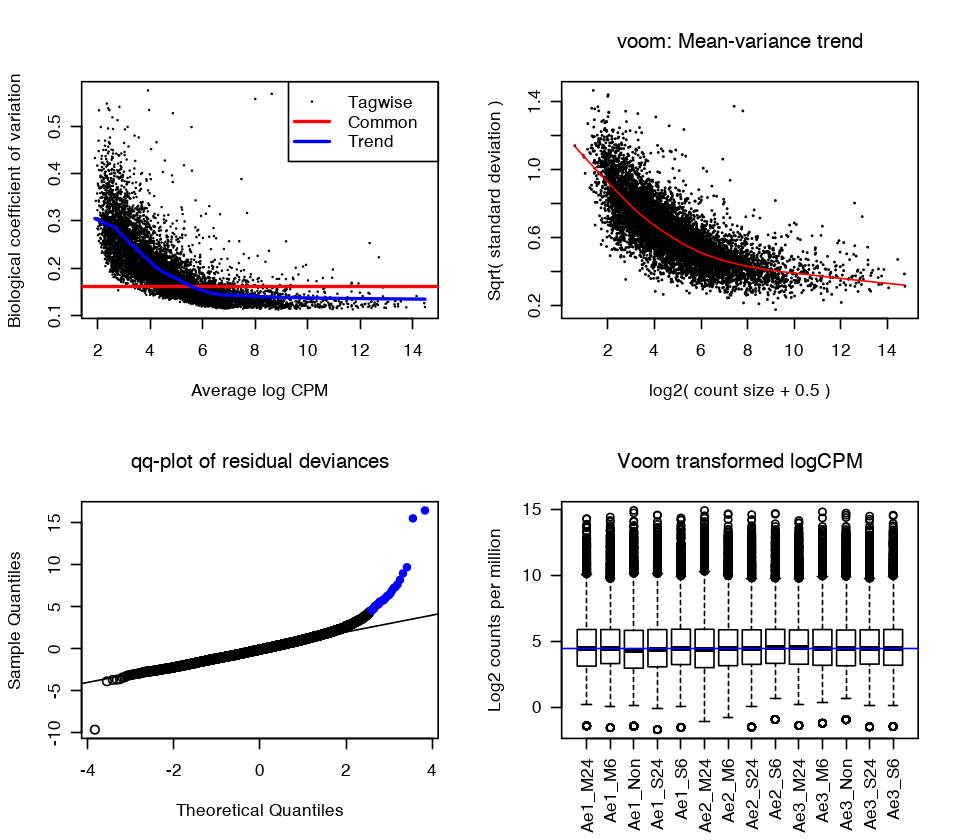

In [63]:
options(repr.plot.width = 8, repr.plot.height = 7)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList_Amaro_Ae_sample)
# mean-variance trend
voom = voom(dgeList_Amaro_Ae_sample, design_2, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_Amaro_Ae_sample_fit, plot = T, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom)

Check the sample grouping:

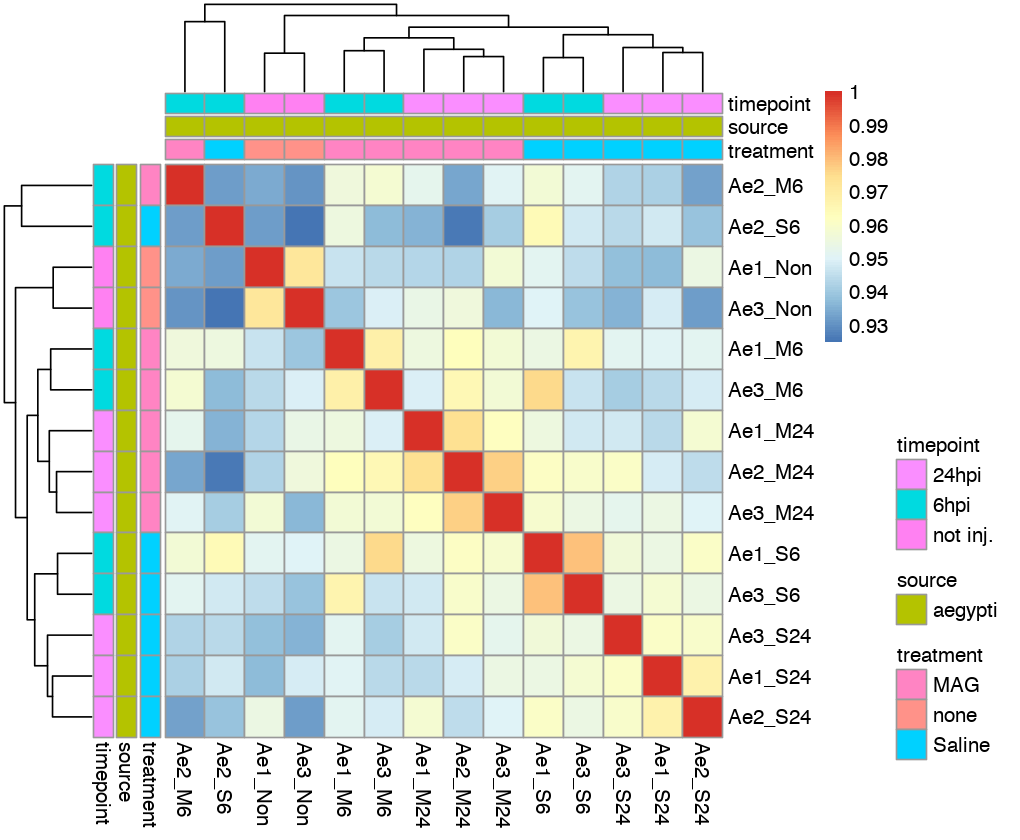

In [66]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts_Amaro_Ae+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')


sampleColLabeling = sample.info_Amaro_Ae
rownames(sampleColLabeling) = sampleColLabeling$replicate
sampleColLabeling = subset(sampleColLabeling, select = c("treatment", "source", "timepoint"))

options(repr.plot.width = 8.5, repr.plot.height = 7)
pheatmap(
  mat               = sample_cor,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
#   filename          = "Results/Figures/Ae_sample_correlations.pdf",
#   width             = 8.5, 
#   height            = 7,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

And MultiDimensional Scaling plot:

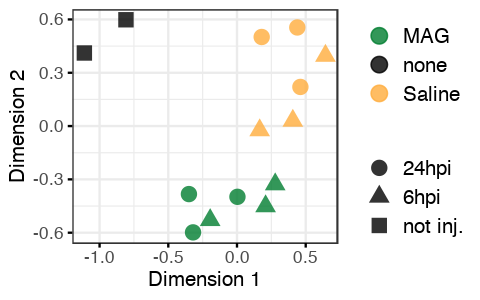

In [177]:
x <- DGEList(counts = RUVrNormalizedCounts_Amaro_Ae, group = groups_Amaro_Ae_sample)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design_Amaro_Ae_sample)
x <- estimateGLMTagwiseDisp(x, design_Amaro_Ae_sample)
x <- estimateGLMTrendedDisp(x, design_Amaro_Ae_sample)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sample.info_Amaro_Ae, by.x = "replicate", by.y = "replicate")

options(repr.plot.width = 4, repr.plot.height = 2.5)
ggscatter(mdsObj,
              x = "dim1", 
              y = "dim2",
              color = "treatment",
              shape = "timepoint",
              size = 4,
              alpha = 0.8, 
#               ellipse = T,
              ggtheme = theme_bw(),
              repel = "timepoint",
         ) + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
#                 theme_monokai_full() +
                labs ( x = "Dimension 1", y = "Dimension 2") +
#                 facet_wrap(~source, scale = "free") +
                scale_colour_manual(values=c("#007d30", "black", "#ffad3d"))

ggsave("Results/Figures/Ae_MDS.pdf", width = 4, height = 2.5)

Add annotation info to DGEList object:

In [72]:
# Extract annotation for genes in the fit object
ann = subset(Annots, gene_id %in% rownames(dgeList_Amaro_Ae_sample_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_Amaro_Ae_sample_fit), ann$gene_id),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "gene_name", "VectorBase_description", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_Amaro_Ae_sample_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_Amaro_Ae_sample_fit$genes = ann
rm(ann)


TRUE 
7778 

Define contrasts, first between the treatment categories:

In [73]:
## Aegypti cohort comparisons
Ae_MAG.vs.Ae_saline <- makeContrasts(Hr6 = Ae_M6 - Ae_S6,
                               Hr24 = Ae_M24 - Ae_S24,
                                  levels = design_2)
Ae_MAG.vs.Ae_none <- makeContrasts(Hr6 = Ae_M6 - Ae_Non,
                                 Hr24 = Ae_M24 - Ae_Non,
                                  levels = design_2)
Ae_saline.vs.Ae_none <- makeContrasts(Hr6 = Ae_S6 - Ae_Non,
                                Hr24 = Ae_S24 - Ae_Non,
                                  levels = design_2)

#### The MAG vs. Saline comparison:

In [87]:
# 6 hour
Ae_Ftest.Hr6.MAG.vs.Saline <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_MAG.vs.Ae_saline[,"Hr6"])
Ae_Ftest.Hr6.MAG.vs.Saline.tTags <- topTags(Ae_Ftest.Hr6.MAG.vs.Saline, n = NULL)
Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table <- Ae_Ftest.Hr6.MAG.vs.Saline.tTags$table
Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table$sig = ifelse(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table$FDR < 0.05, "yes", "no")
Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table$time = "Hr6"
nrow(subset(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table, sig == "yes"))

[1] 3

In [88]:
# 24 hour
Ae_Ftest.Hr24.MAG.vs.Saline <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_MAG.vs.Ae_saline[,"Hr24"])
Ae_Ftest.Hr24.MAG.vs.Saline.tTags <- topTags(Ae_Ftest.Hr24.MAG.vs.Saline, n = NULL)
Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table <- Ae_Ftest.Hr24.MAG.vs.Saline.tTags$table
Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table$sig = ifelse(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table$FDR < 0.05, "yes", "no")
Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table$time = "Hr24"
nrow(subset(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table, sig == "yes"))

[1] 87

Output tables:

In [121]:
tmp6_Ae <- subset(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table, sig == "yes")
tmp6_Ae$direction <- ifelse(tmp6_Ae$logFC > 0, "up-regulated", "down-regulated")
tmp24_Ae <- subset(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table, sig == "yes")
tmp24_Ae$direction <- ifelse(tmp24_Ae$logFC > 0, "up-regulated", "down-regulated")
Ae_MAG.vs.Saline_DE_genes <- rbind(tmp6_Ae, tmp24_Ae)
write.table(Ae_MAG.vs.Saline_DE_genes, "Results/Tables/Ae_MAG.vs.Ae_Saline_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Ae, tmp24_Ae)

Check the qq-plot for this contrast:

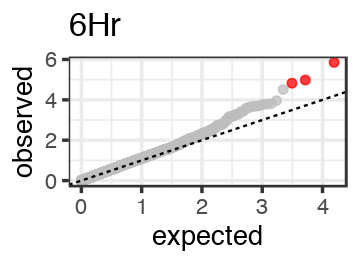

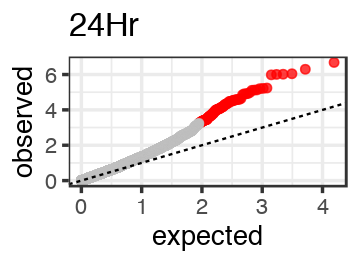

In [89]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table$FDR < 0.05)) + ggtitle("6Hr")
ggplot.qq(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table$FDR < 0.05)) + ggtitle("24Hr")

And a volcano plot:

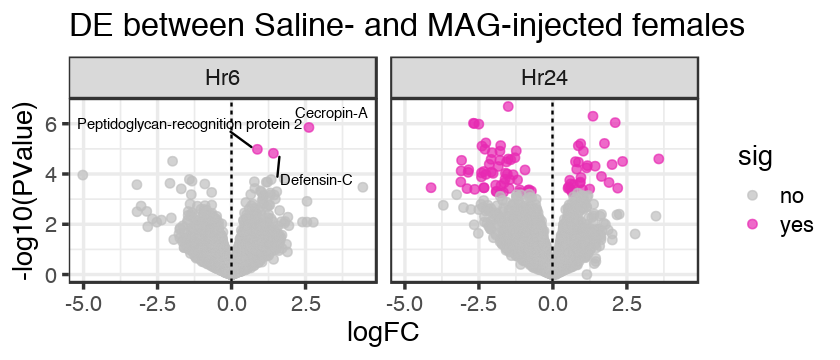

In [90]:
Ae_Ftest.MAG.vs.Saline.tTags.table = rbind(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table, Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table)
Ae_Ftest.MAG.vs.Saline.tTags.table$comparison = "MAG.vs.Saline"
Ae_Ftest.MAG.vs.Saline.tTags.table$time = factor(Ae_Ftest.MAG.vs.Saline.tTags.table$time, levels = c("Hr6", "Hr24"))

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Ae_Ftest.MAG.vs.Saline.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time) +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#e728b2")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black") +
    geom_text_repel(data = subset(Ae_Ftest.MAG.vs.Saline.tTags.table, time == "Hr6" & sig == "yes"), aes(logFC, -log10(PValue),label=SwissProt_BlastX_Description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    ggtitle("DE between Saline- and MAG-injected females")
ggsave("Results/Figures/Ae_MAG.vs.Ae_Saline_VolcanoPlots.pdf", width = 6, height = 3)

Three immune genes are significant between MAG-injected and saline-injected RTs at 6 hours. Let's plot them separately:

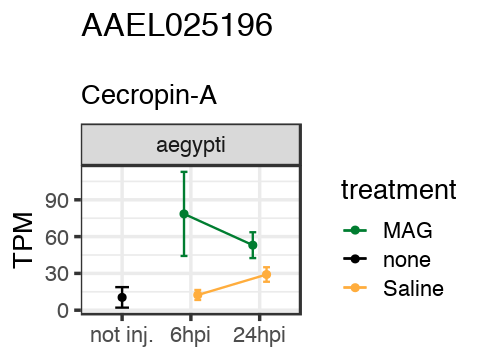

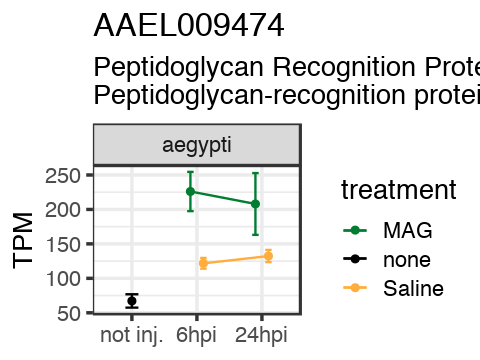

Saving 7 x 7 in image



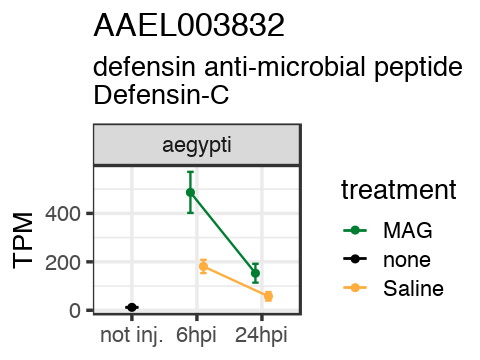

In [106]:
options(repr.plot.width = 4, repr.plot.height = 3)
genePointPlot_Amaro(tpmTable = filter(Amaro.geneTPM.table, source == "aegypti"), "AAEL025196")
genePointPlot_Amaro(tpmTable = filter(Amaro.geneTPM.table, source == "aegypti"), "AAEL009474")
genePointPlot_Amaro(tpmTable = filter(Amaro.geneTPM.table, source == "aegypti"), "AAEL003832")
mag.v.saline.immuneGenes = suppressMessages(lapply(subset(Ae_Ftest.MAG.vs.Saline.tTags.table, time == "Hr6" & sig == "yes")$GeneID, genePointPlot_Amaro, tpmTable = filter(Amaro.geneTPM.table, source == "aegypti")))
ggsave("Results/Figures/Ae_mag.v.saline.immuneGenes.pdf", marrangeGrob(grobs = mag.v.saline.immuneGenes, nrow = 2, ncol =1))

Let's run a GO analysis on the set of DE genes at 24hr after injection in this comparison:

In [108]:
Ae_MAG.vs.Ae_Saline.Hr24.up = subset(Ae_Ftest.MAG.vs.Saline.tTags.table, sig == "yes" & time == "Hr24" & logFC > 0)$GeneID
Ae_MAG.vs.Ae_Saline.Hr24.down = subset(Ae_Ftest.MAG.vs.Saline.tTags.table, sig == "yes" & time == "Hr24" & logFC < 0)$GeneID

No categories are enriched in the genes that higher expression in MAG-injected fRTs. Look at those with lower expression in the MAG-injected fRTs:

Warning message in pcls(G):
"initial point very close to some inequality constraints"


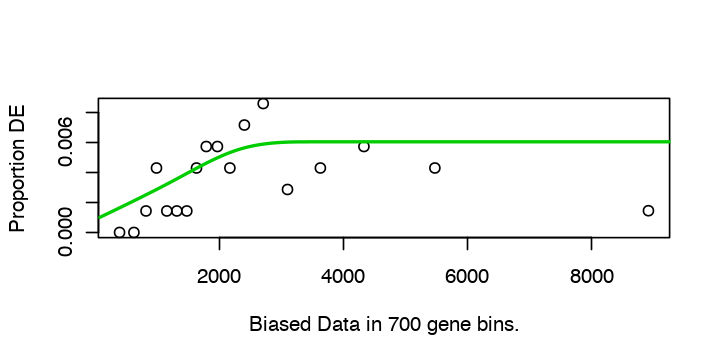

In [102]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Ae_MAG.vs.Saline.Hr24.down)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [104]:
cat_genes_vec = as.integer(features_with_GO %in% Ae_MAG.vs.Saline.Hr24.down)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
subset(enrich_result_table, over_represented_FDR < 0.05)
write.table(enrich_result_table, file = "Results/Tables/Ae_GO_results_MAG.vs.Saline.Hr24.SalineUp.txt", quote = F, sep = "\t")

Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



,category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term
,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>
5817,GO:0022414,5.333537e-09,1.0000000,18,959,reproductive process,BP,7.891502e-05,BP reproductive process
2909,GO:0007276,2.351627e-08,1.0000000,11,301,gamete generation,BP,1.011863e-04,BP gamete generation
9277,GO:0044702,2.651796e-08,1.0000000,16,787,NA,NA,1.011863e-04,none
5816,GO:0022412,3.008414e-08,1.0000000,13,462,cellular process involved in reproduction in multicellular organism,BP,1.011863e-04,BP cellular process involved in reproduction in multicellular organism
10455,GO:0048609,3.419381e-08,1.0000000,12,397,multicellular organismal reproductive process,BP,1.011863e-04,BP multicellular organismal reproductive process
924,GO:0003006,3.246999e-07,1.0000000,14,699,developmental process involved in reproduction,BP,7.783303e-04,BP developmental process involved in reproduction
10384,GO:0048477,3.682287e-07,1.0000000,8,167,oogenesis,BP,7.783303e-04,BP oogenesis
2924,GO:0007292,4.838125e-07,1.0000000,8,173,female gamete generation,BP,8.948112e-04,BP female gamete generation
2914,GO:0007281,2.094139e-06,0.9999998,8,215,germ cell development,BP,3.442765e-03,BP germ cell development


Let's output a PDF of all the genes that are DE between MAG- and Saline-injected females

In [110]:
Ae_mag.v.Ae_saline.MAGup24 = suppressMessages(lapply(Ae_MAG.vs.Ae_Saline.Hr24.up, genePointPlot_Amaro, tpmTable = filter(Amaro.geneTPM.table, source == "aegypti")))
ggsave("Results/Figures/Ae_mag.v.saline.MAGup24.pdf", marrangeGrob(grobs = Ae_mag.v.Ae_saline.MAGup24, nrow = 2, ncol =1))

Saving 7 x 7 in image



In [111]:
Ae_mag.v.Ae_saline.Salineup24 = suppressMessages(lapply(Ae_MAG.vs.Ae_Saline.Hr24.down, genePointPlot_Amaro, tpmTable = filter(Amaro.geneTPM.table, source == "aegypti")))
ggsave("Results/Figures/Ae_mag.v.saline.Salineup24.pdf", marrangeGrob(grobs = Ae_mag.v.Ae_saline.Salineup24, nrow = 2, ncol =1))

Saving 7 x 7 in image



#### For MAG vs. none:

In [116]:
Ae_Ftest.Hr6.MAG.vs.none <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_MAG.vs.Ae_none[,"Hr6"])
Ae_Ftest.Hr6.MAG.vs.none.tTags <- topTags(Ae_Ftest.Hr6.MAG.vs.none, n = NULL)
Ae_Ftest.Hr6.MAG.vs.none.tTags.table <- Ae_Ftest.Hr6.MAG.vs.none.tTags$table
Ae_Ftest.Hr6.MAG.vs.none.tTags.table$sig = ifelse(Ae_Ftest.Hr6.MAG.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr6.MAG.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr6.MAG.vs.none.tTags.table$logFC < -1), "yes", "no")
Ae_Ftest.Hr6.MAG.vs.none.tTags.table$time = "Hr6"
nrow(subset(Ae_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes"))

[1] 146

In [117]:
Ae_Ftest.Hr24.MAG.vs.none <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_MAG.vs.Ae_none[,"Hr24"])
Ae_Ftest.Hr24.MAG.vs.none.tTags <- topTags(Ae_Ftest.Hr24.MAG.vs.none, n = NULL)
Ae_Ftest.Hr24.MAG.vs.none.tTags.table <- Ae_Ftest.Hr24.MAG.vs.none.tTags$table
Ae_Ftest.Hr24.MAG.vs.none.tTags.table$sig = ifelse(Ae_Ftest.Hr24.MAG.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr24.MAG.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr24.MAG.vs.none.tTags.table$logFC < -1), "yes", "no")
Ae_Ftest.Hr24.MAG.vs.none.tTags.table$time = "Hr24"
nrow(subset(Ae_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes"))

[1] 129

Output tables

In [122]:
tmp6_Ae <- subset(Ae_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes")
tmp6_Ae$direction <- ifelse(tmp6_Ae$logFC > 0, "up-regulated", "down-regulated")
tmp24_Ae <- subset(Ae_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes")
tmp24_Ae$direction <- ifelse(tmp24_Ae$logFC > 0, "up-regulated", "down-regulated")
Ae_MAG.vs.none_DE_genes <- rbind(tmp6_Ae, tmp24_Ae)
write.table(Ae_MAG.vs.none_DE_genes, "Results/Tables/Ae_MAG.vs.Ae_none_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Ae, tmp24_Ae)

Check the qq-plot for this contrast:

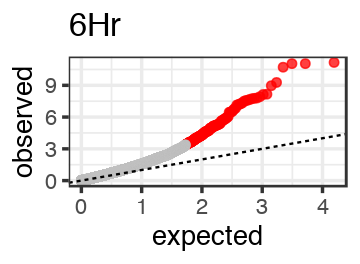

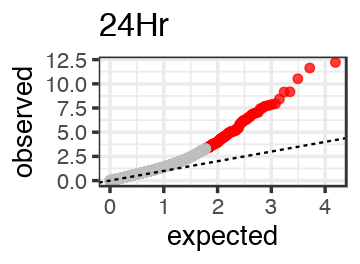

In [119]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Ae_Ftest.Hr6.MAG.vs.none.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr6.MAG.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr6.MAG.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr6.MAG.vs.none.tTags.table$logFC < -1))) + ggtitle("6Hr")
ggplot.qq(Ae_Ftest.Hr24.MAG.vs.none.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr24.MAG.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr24.MAG.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr24.MAG.vs.none.tTags.table$logFC < -1))) + ggtitle("24Hr")

And a volcano plot:

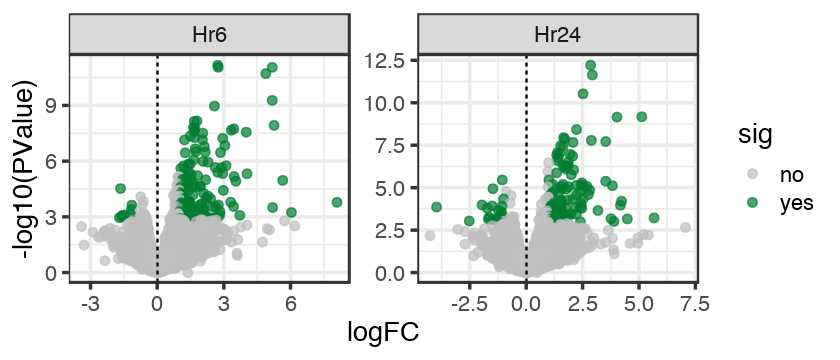

In [125]:
Ae_Ftest.MAG.vs.none.tTags.table = rbind(Ae_Ftest.Hr6.MAG.vs.none.tTags.table, Ae_Ftest.Hr24.MAG.vs.none.tTags.table)
Ae_Ftest.MAG.vs.none.tTags.table$comparison = "MAG.vs.none"
Ae_Ftest.MAG.vs.none.tTags.table$time = factor(Ae_Ftest.MAG.vs.none.tTags.table$time, levels = c("Hr6", "Hr24"))

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Ae_Ftest.MAG.vs.none.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time, scales = "free") +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#007d30")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black")
ggsave("Results/Figures/Ae_MAG.vs.Ae_none_VolcanoPlots.pdf", width = 5, height = 3)

#### For Saline vs. none:

In [126]:
Ae_Ftest.Hr6.Saline.vs.none <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_saline.vs.Ae_none[,"Hr6"])
Ae_Ftest.Hr6.Saline.vs.none.tTags <- topTags(Ae_Ftest.Hr6.Saline.vs.none, n = NULL)
Ae_Ftest.Hr6.Saline.vs.none.tTags.table <- Ae_Ftest.Hr6.Saline.vs.none.tTags$table
Ae_Ftest.Hr6.Saline.vs.none.tTags.table$sig = ifelse(Ae_Ftest.Hr6.Saline.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr6.Saline.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr6.Saline.vs.none.tTags.table$logFC < -1), "yes", "no")
Ae_Ftest.Hr6.Saline.vs.none.tTags.table$time = "Hr6"
nrow(subset(Ae_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes"))

[1] 133

In [127]:
Ae_Ftest.Hr24.Saline.vs.none <- glmQLFTest(dgeList_Amaro_Ae_sample_fit, contrast = Ae_saline.vs.Ae_none[,"Hr24"])
Ae_Ftest.Hr24.Saline.vs.none.tTags <- topTags(Ae_Ftest.Hr24.Saline.vs.none, n = NULL)
Ae_Ftest.Hr24.Saline.vs.none.tTags.table <- Ae_Ftest.Hr24.Saline.vs.none.tTags$table
Ae_Ftest.Hr24.Saline.vs.none.tTags.table$sig = ifelse(Ae_Ftest.Hr24.Saline.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr24.Saline.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr24.Saline.vs.none.tTags.table$logFC < -1), "yes", "no")
Ae_Ftest.Hr24.Saline.vs.none.tTags.table$time = "Hr24"
nrow(subset(Ae_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes"))

[1] 132

Output tables

In [129]:
tmp6_Ae <- subset(Ae_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes")
tmp6_Ae$direction <- ifelse(tmp6_Ae$logFC > 0, "up-regulated", "down-regulated")
tmp24_Ae <- subset(Ae_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes")
tmp24_Ae$direction <- ifelse(tmp24_Ae$logFC > 0, "up-regulated", "down-regulated")
Ae_Saline.vs.none_DE_genes <- rbind(tmp6_Ae, tmp24_Ae)
write.table(Ae_Saline.vs.none_DE_genes, "Results/Tables/Ae_Saline.vs.Ae_none_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Ae, tmp24_Ae)

Check the qq-plot for this contrast:

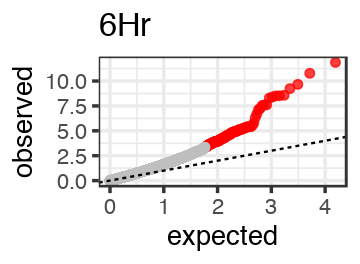

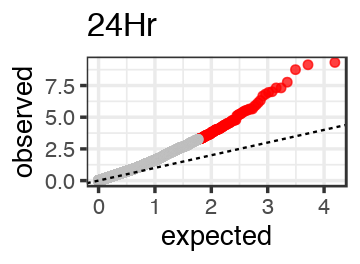

In [132]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Ae_Ftest.Hr6.Saline.vs.none.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr6.Saline.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr6.Saline.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr6.Saline.vs.none.tTags.table$logFC < -1))) + ggtitle("6Hr")
ggplot.qq(Ae_Ftest.Hr24.Saline.vs.none.tTags.table$PValue, hit.idx = which(Ae_Ftest.Hr24.Saline.vs.none.tTags.table$FDR < 0.05 & (Ae_Ftest.Hr24.Saline.vs.none.tTags.table$logFC > 1 | Ae_Ftest.Hr24.Saline.vs.none.tTags.table$logFC < -1))) + ggtitle("24Hr")

And a volcano plot:

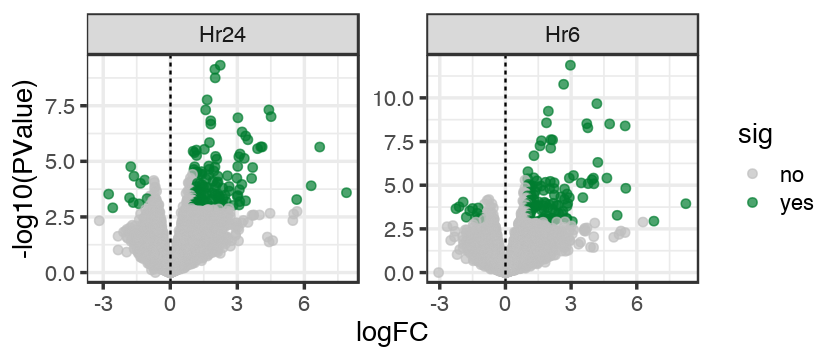

In [133]:
Ae_Ftest.Saline.vs.none.tTags.table = rbind(Ae_Ftest.Hr6.Saline.vs.none.tTags.table, Ae_Ftest.Hr24.Saline.vs.none.tTags.table)
Ae_Ftest.Saline.vs.none.tTags.table$comparison = "Saline.vs.none"

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Ae_Ftest.Saline.vs.none.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time, scales = "free") +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#007d30")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black")
ggsave("Results/Figures/Ae_Saline.vs.Ae_none_VolcanoPlots.pdf", width = 5, height = 3)

Look at the overlap between DE genes at 6hpi from this study DE genes at 6hpm from the Alfona study:

                   Length Class  Mode     
MAG                 64    -none- character
Saline              51    -none- character
Alfonso            218    -none- character
MAG,Saline          72    -none- character
MAG,Alfonso          3    -none- character
Saline,Alfonso       3    -none- character
MAG,Saline,Alfonso   7    -none- character

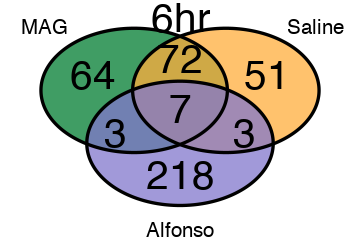

In [134]:
Ae_Hr6Overlap_candidates <- list(MAG = subset(Ae_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes")$GeneID, 
                        Saline = subset(Ae_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes")$GeneID,
                          Alfonso = c(Alfonso_6hpm_v_virgin_sigGene_down, Alfonso_6hpm_v_virgin_sigGene_up))

Ae_Hr6Overlap_Vdiag<-venn.diagram(Ae_Hr6Overlap_candidates, NULL, fill=c("#007d30", "#ffad3d", "#8277cc"), alpha=c(0.75,0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, main = "6hr", main.cex = 2, cat.dist = c(0.1, 0.1, 0.1), main.dist = -0.9)

Ae_Hr6Overlap_combs <- unlist(lapply(1:length(Ae_Hr6Overlap_candidates), function(j) combn(names(Ae_Hr6Overlap_candidates), j, simplify = FALSE)), recursive = FALSE)
names(Ae_Hr6Overlap_combs) <- sapply(Ae_Hr6Overlap_combs, function(i) paste0(i, collapse = ","))
Ae_Hr6Overlap_elements <- lapply(Ae_Hr6Overlap_combs, function(i) Setdiff(Ae_Hr6Overlap_candidates[i], Ae_Hr6Overlap_candidates[setdiff(names(Ae_Hr6Overlap_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=Ae_Hr6Overlap_Vdiag))
summary(Ae_Hr6Overlap_elements)
rm(Ae_Hr6Overlap_candidates, Ae_Hr6Overlap_Vdiag, Ae_Hr6Overlap_combs)

Look at the overlap between DE genes at 24hpi from this study DE genes at 6hpm from the Alfona study:

                   Length Class  Mode     
MAG                 62    -none- character
Saline              88    -none- character
Alfonso            322    -none- character
MAG,Saline          36    -none- character
MAG,Alfonso         25    -none- character
Saline,Alfonso       2    -none- character
MAG,Saline,Alfonso   6    -none- character

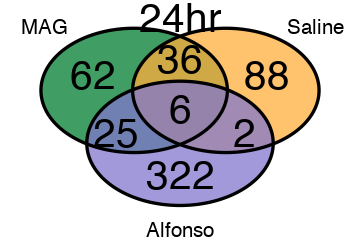

In [135]:
Ae_Hr24Overlap_candidates <- list(MAG = subset(Ae_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes")$GeneID, 
                        Saline = subset(Ae_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes")$GeneID,
                          Alfonso = c(Alfonso_24hpm_v_virgin_sigGene_down, Alfonso_24hpm_v_virgin_sigGene_up))

Ae_Hr24Overlap_Vdiag<-venn.diagram(Ae_Hr24Overlap_candidates, NULL, fill=c("#007d30", "#ffad3d", "#8277cc"), alpha=c(0.75,0.75,0.75), cex = 2, cat.fontface= 24, cat.cex = 1, resolution = 100, main = "24hr", main.cex = 2, cat.dist = c(0.1, 0.1, 0.1), main.dist = -0.9)

Ae_Hr24Overlap_combs <- unlist(lapply(1:length(Ae_Hr24Overlap_candidates), function(j) combn(names(Ae_Hr24Overlap_candidates), j, simplify = FALSE)), recursive = FALSE)
names(Ae_Hr24Overlap_combs) <- sapply(Ae_Hr24Overlap_combs, function(i) paste0(i, collapse = ","))
Ae_Hr24Overlap_elements <- lapply(Ae_Hr24Overlap_combs, function(i) Setdiff(Ae_Hr24Overlap_candidates[i], Ae_Hr24Overlap_candidates[setdiff(names(Ae_Hr24Overlap_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=Ae_Hr24Overlap_Vdiag))
summary(Ae_Hr24Overlap_elements)
rm(Ae_Hr24Overlap_candidates, Ae_Hr24Overlap_Vdiag, Ae_Hr24Overlap_combs)

Let's plot the log fold change between the two studies (MAG injection and post-mating)

In [228]:
tmpAmaro6hpi = select(Ae_Ftest.Hr6.MAG.vs.none.tTags.table, GeneID, Am_logFC = logFC, Am_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAlfonso6hpi = select(Ftest.hpm6.v.virgin.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
tmp6hr = merge(tmpAmaro6hpi, tmpAlfonso6hpi, by.x = "GeneID", by.y = "GeneID", all = T)
tmp6hr$time = "Hr6"
tmpAmaro24hpi = select(Ae_Ftest.Hr24.MAG.vs.none.tTags.table, GeneID, Am_logFC = logFC, Am_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAlfonso24hpi = select(Ftest.hpm24.v.virgin.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
tmp24hr = merge(tmpAmaro24hpi, tmpAlfonso24hpi, by.x = "GeneID", by.y = "GeneID", all = T)
tmp24hr$time = "Hr24"
Ae_Alfonso_Amaro_logFC = rbind(tmp6hr, tmp24hr)
Ae_Alfonso_Amaro_logFC_comparison <- filter(tmpDF, Am_sig == "yes" | Al_sig == "sig")
write.table(Ae_Alfonso_Amaro_logFC_comparison, "Results/Tables/Ae_Alfonso_Amaro_logFC_comparison.txt", quote = F, row.names = F, sep = "\t")

Warning message:
"Removed 1797 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 66 rows containing missing values (geom_point)."
Warning message:
"Removed 1797 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 66 rows containing missing values (geom_point)."


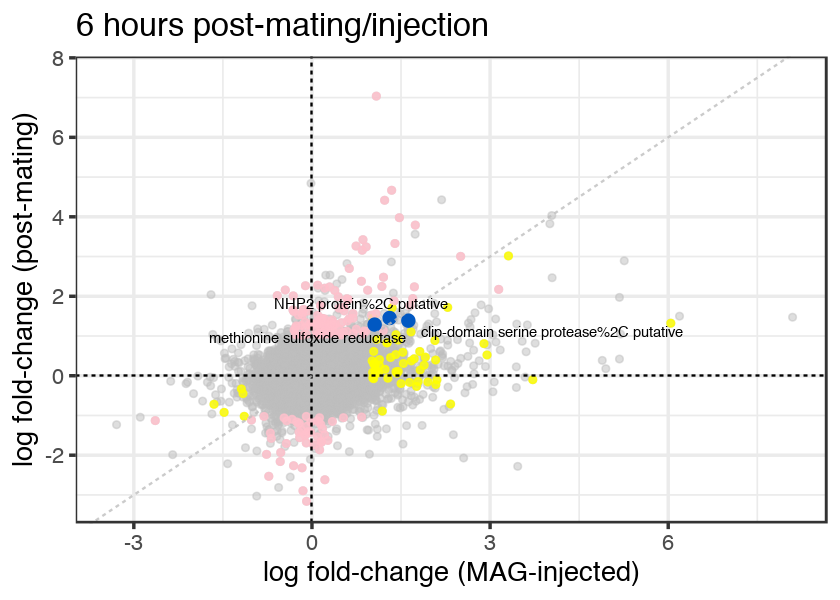

In [229]:
options(repr.plot.width = 7, repr.plot.height =5)
ggplot() +
    geom_point(data = subset(tmp6hr, GeneID %!in% Ae_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "gray", alpha = 0.5) +
    geom_point(data = subset(tmp6hr, GeneID %in% Ae_Hr6Overlap_elements$MAG), aes(Am_logFC, Al_logFC), colour = "yellow", alpha = 0.8) +
    geom_point(data = subset(tmp6hr, GeneID %in% Ae_Hr6Overlap_elements$Alfonso), aes(Am_logFC, Al_logFC), colour = "pink", alpha = 0.8) +
    geom_point(data = subset(tmp6hr, GeneID %in% Ae_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "#0158c2", size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_text_repel(data = subset(tmp6hr, GeneID %in% Ae_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC,label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(x = "log fold-change (MAG-injected)", y = "log fold-change (post-mating)") +
    ggtitle("6 hours post-mating/injection") +
    scale_y_continuous(limits = c(NA, 7.5))
ggsave("Results/Figures/Ae_Hr6.LogFC_comparison_injection.vs.mating.pdf", width = 7, height = 5)

Warning message:
"Removed 1796 rows containing missing values (geom_point)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
Warning message:
"Removed 83 rows containing missing values (geom_point)."
Warning message:
"Removed 12 rows containing missing values (geom_text_repel)."
Warning message:
"Removed 1796 rows containing missing values (geom_point)."
Warning message:
"Removed 7 rows containing missing values (geom_point)."
Warning message:
"Removed 83 rows containing missing values (geom_point)."
Warning message:
"Removed 12 rows containing missing values (geom_text_repel)."


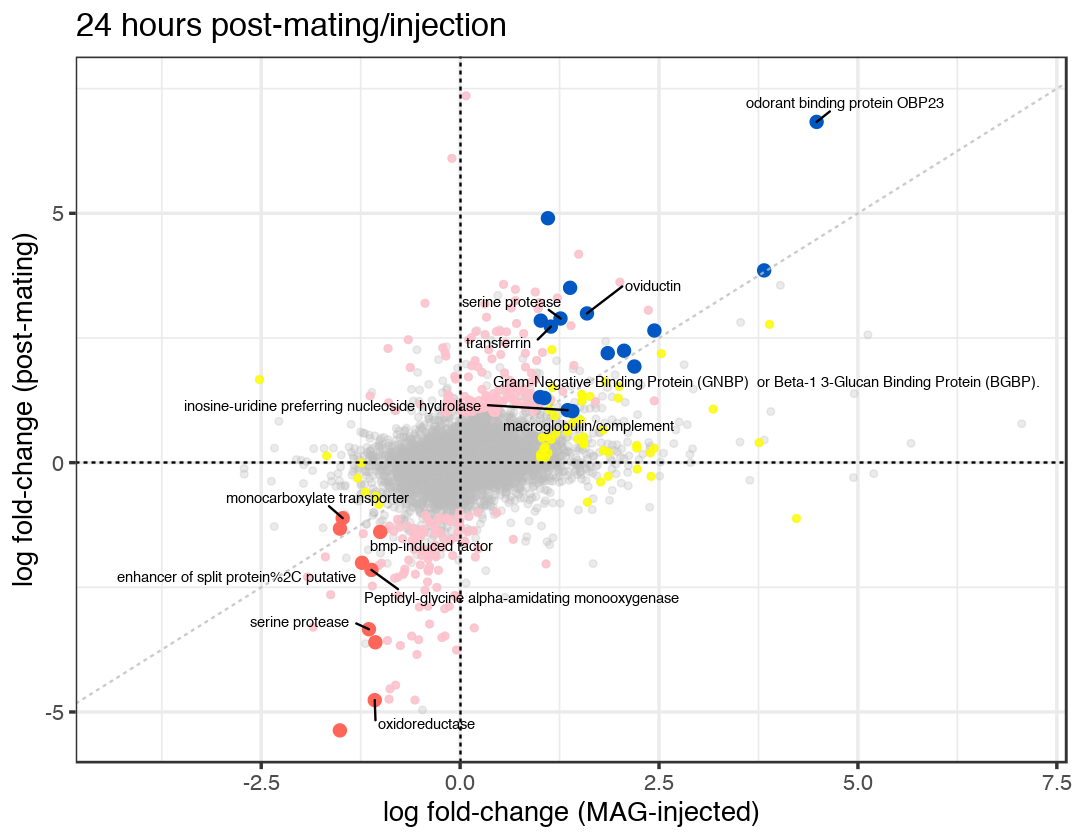

In [230]:
options(repr.plot.width = 9, repr.plot.height =7)
ggplot() +
    geom_point(data = subset(tmp24hr, GeneID %!in% Ae_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "gray", alpha = 0.3) +
    geom_point(data = subset(tmp24hr, GeneID %in% Ae_Hr24Overlap_elements$MAG), aes(Am_logFC, Al_logFC), colour = "yellow", alpha = 0.8) +
    geom_point(data = subset(tmp24hr, GeneID %in% Ae_Hr24Overlap_elements$Alfonso), aes(Am_logFC, Al_logFC), colour = "pink", alpha = 0.8) +
    geom_point(data = subset(tmp24hr, GeneID %in% Ae_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC > 0), aes(Am_logFC, Al_logFC), colour = "#0158c2", size = 3) +
    geom_point(data = subset(tmp24hr, GeneID %in% Ae_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC < 0), aes(Am_logFC, Al_logFC), colour = "#ff6659", size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_text_repel(data = subset(tmp24hr, GeneID %in% Ae_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC,label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(x = "log fold-change (MAG-injected)", y = "log fold-change (post-mating)") +
    ggtitle("24 hours post-mating/injection") +
    scale_y_continuous(limits = c(NA, 7.5))
ggsave("Results/Figures/Ae_Hr24.LogFC_comparison_injection.vs.mating.pdf", width = 9, height = 7)

### Albopictus MAG injections:

Restrict the samples to the albopictus MAG treatment:

In [167]:
counts_qM_Amaro_Al = select(counts_qM_Amaro, contains("Al"))
sample.info_Amaro_Al = filter(sample.info_Amaro, source == "albopictus")

Restrict the samples to the aegypti MAG treatment:

In [168]:
counts_qM_Amaro_Al = select(counts_qM_Amaro, contains("Al"))
sample.info_Amaro_Al = filter(sample.info_Amaro, source == "albopictus")

Now filter the counts:

In [169]:
cpm_qM_Amaro_Al <- cpm(counts_qM_Amaro_Al)
thresh_qM_Amaro_Al <- cpm_qM_Amaro_Al > 5
keep_qM_Amaro_Al <- rowSums(thresh_qM_Amaro_Al) >= 3
countsKeep_qM_Amaro_Al <- counts_qM_Amaro_Al[keep_qM_Amaro_Al,]
# countsKeep_qM <- subset(countsKeep_qM, rownames(countsKeep_qM) %!in% wierd_genes)
table(keep_qM_Amaro_Al)

keep_qM_Amaro_Al
FALSE  TRUE 
12538  7174 

Define groups for differential expression:

In [170]:
groups_Amaro_Al_sample = factor(sample.info_Amaro_Al$sample)
design_Amaro_Al_sample = model.matrix(~0+groups_Amaro_Al_sample)
colnames(design_Amaro_Al_sample) <- levels(groups_Amaro_Al_sample)
rownames(design_Amaro_Al_sample) <- sample.info_Amaro_Al$replicate

Adjust counts with RUVseq residuals:

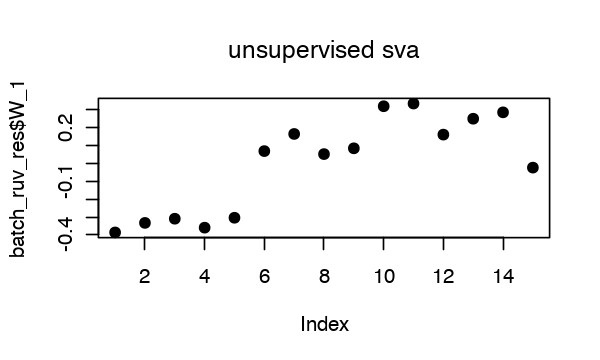

In [171]:
set <- newSeqExpressionSet(as.matrix(countsKeep_qM_Amaro_Al), phenoData = data.frame(groups_Amaro_Al_sample, row.names = colnames(countsKeep_qM_Amaro_Al)))
set <- betweenLaneNormalization(set, which="upper")

y <- DGEList(counts=counts(set), group=groups_Amaro_Al_sample)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateDisp(y, design_Amaro_Al_sample, robust = T)
fit <- glmQLFit(y, design_Amaro_Al_sample, dispersion = y$tagwise.dispersion, robust = T)
res <- residuals(fit, type="deviance")

batch_ruv_res = RUVr(set,rownames(countsKeep_qM_Amaro_Al),k=3,res)
RUVrNormalizedCounts = normCounts(object = batch_ruv_res)
rownames(RUVrNormalizedCounts) = rownames(countsKeep_qM_Amaro_Al)

RUVrNormalizedTPM = tpm(counts = RUVrNormalizedCounts, lengths = 2922)

tmp.tpmMatrix<-RUVrNormalizedTPM
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
colnames(tmp.tpmMatrix.m) <- c("gene_id", "replicate", "TPM")
Amaro_Al.geneTPM.table.rc <- merge(sample.info_Amaro_Al, tmp.tpmMatrix.m, by.x = "replicate", by.y = "replicate", all.y = T)
rm(tmp.tpmMatrix, tmp.tpmMatrix.m)

design_2 <- model.matrix(~ 0 + groups_Amaro_Al_sample + W_1 + W_2 + W_3, data=pData(batch_ruv_res))
colnames(design_2) <- gsub("groups_Amaro_Al_sample", "", colnames(design_2))

options(repr.plot.width = 5, repr.plot.height = 3)
plot(batch_ruv_res$W_1,pch=19,main="unsupervised sva")

Fit the DGE model:

In [172]:
dgeList_Amaro_Al_sample <- DGEList(counts = countsKeep_qM_Amaro_Al, group = groups_Amaro_Al_sample)
dgeList_Amaro_Al_sample <- calcNormFactors(dgeList_Amaro_Al_sample)
dgeList_Amaro_Al_sample <- estimateDisp(dgeList_Amaro_Al_sample, design_2)
dgeList_Amaro_Al_sample_fit <- glmQLFit(dgeList_Amaro_Al_sample, design_2)
summary(dgeList_Amaro_Al_sample$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01198 0.02402 0.03573 0.05056 0.06110 1.00137 

Check some of the model fitting parameters:

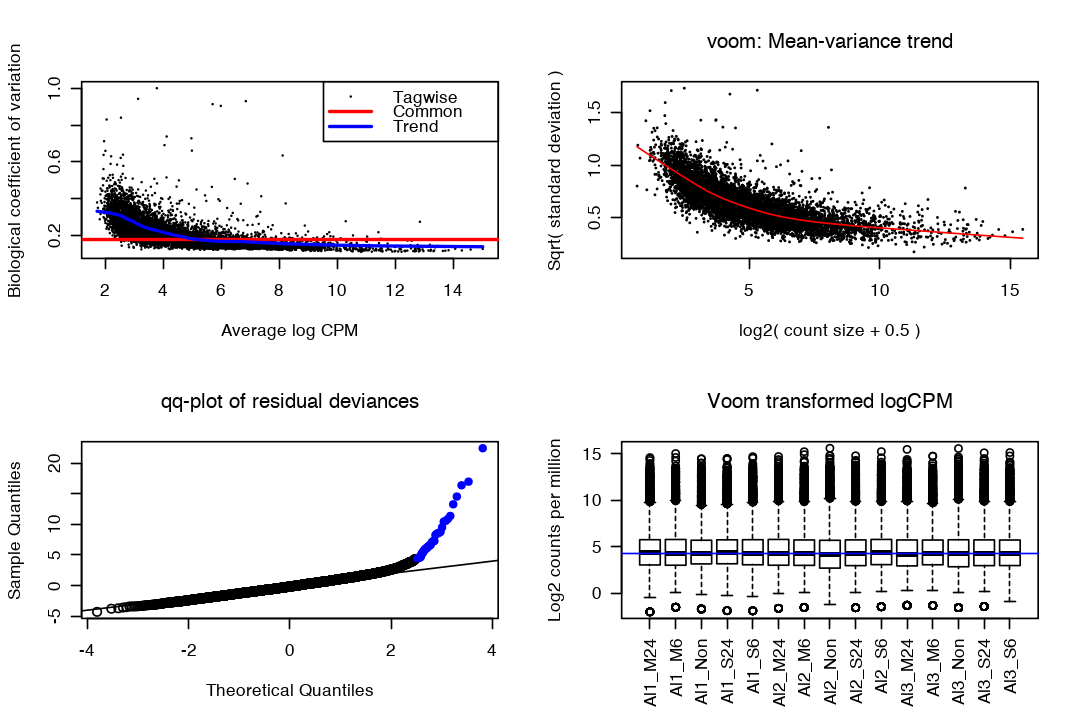

In [173]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList_Amaro_Al_sample)
# mean-variance trend
voom = voom(dgeList_Amaro_Al_sample, design_2, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList_Amaro_Al_sample_fit, plot = T, pcutoff = 0.05, adjust = "holm")
# z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
# qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(voom$E),col="blue")

rm(voom)

Check the sample grouping:

In [175]:
## Plot sample correlation
data = log2(RUVrNormalizedCounts+1)
# colnames(data) = gsub("Female_", "", colnames(data))
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')


sampleColLabeling = sample.info_Amaro_Al
rownames(sampleColLabeling) = sampleColLabeling$replicate
sampleColLabeling = subset(sampleColLabeling, select = c("treatment", "source", "timepoint"))

options(repr.plot.width = 8.5, repr.plot.height = 7)
pheatmap(
  mat               = sample_cor,
  show_colnames     = TRUE,
  show_rownames     = TRUE,
  annotation_col    = sampleColLabeling,
  annotation_row    = sampleColLabeling,
  filename          = "Results/Figures/Al_sample_correlations.pdf",
  width             = 8.5, 
  height            = 7,
  fontsize          = 12    
)
rm(data)
rm(sample_cor)

And MultiDimensional Scaling plot:

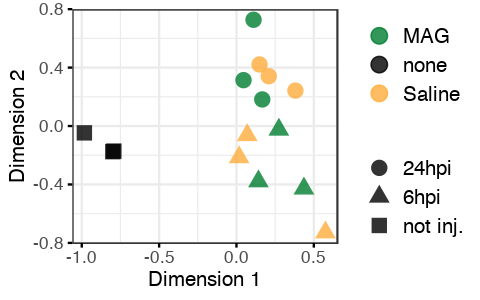

In [180]:
x <- DGEList(counts = RUVrNormalizedCounts, group = groups_Amaro_Al_sample)
suppressWarnings(x <- calcNormFactors(x))
x <- estimateGLMCommonDisp(x, design_Amaro_Al_sample)
x <- estimateGLMTagwiseDisp(x, design_Amaro_Al_sample)
x <- estimateGLMTrendedDisp(x, design_Amaro_Al_sample)

mdsObj <- plotMDS(x, plot = F)$cmdscale.out
mdsObj <- as.data.frame(as.matrix(mdsObj))
mdsObj$replicate <- rownames(mdsObj)
colnames(mdsObj) = c("dim1", "dim2", "replicate")
mdsObj = merge(mdsObj, sample.info_Amaro_Al, by.x = "replicate", by.y = "replicate")

options(repr.plot.width = 4, repr.plot.height = 2.5)
ggscatter(mdsObj,
              x = "dim1", 
              y = "dim2",
              color = "treatment",
              shape = "timepoint",
              size = 4,
              alpha = 0.8, 
#               ellipse = T,
              ggtheme = theme_bw(),
              repel = "timepoint",
         ) + 
                theme(axis.text = element_text(size = 10), legend.title = element_blank(), axis.title = element_text(size = 12), legend.text = element_text(size = 12)) +
#                 theme_monokai_full() +
                labs ( x = "Dimension 1", y = "Dimension 2") +
                scale_colour_manual(values=c("#007d30", "black", "#ffad3d"))

ggsave("Results/Figures/Al_MDS.pdf", width = 4, height = 2.5)

Add annotation info to DGEList object:

In [181]:
# Extract annotation for genes in the fit object
ann = subset(Annots, gene_id %in% rownames(dgeList_Amaro_Al_sample_fit))
# convert factors to characters
ann = data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann = ann[match(rownames(dgeList_Amaro_Al_sample_fit), ann$gene_id),]
# convert factors to characters, again
ann <- data.frame(lapply(ann, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann) = c ("GeneID", "gene_name", "VectorBase_description", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann$GeneID==rownames(dgeList_Amaro_Al_sample_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList_Amaro_Al_sample_fit$genes = ann
rm(ann)


TRUE 
7174 

Define contrasts, first between the treatment categories:

In [206]:
Al_MAG.vs.Al_saline <- makeContrasts(Hr6 = Al_M6 - Al_S6,
                               Hr24 = Al_M24 - Al_S24,
                                  levels = design_2)
Al_MAG.vs.Al_none <- makeContrasts(Hr6 = Al_M6 - Al_Non,
                             Hr24 = Al_M24 - Al_Non,
                                  levels = design_2)
Al_saline.vs.Al_none <- makeContrasts(Hr6 = Al_S6 - Al_Non,
                                Hr24 = Al_S24 - Al_Non,
                                  levels = design_2)


#### The MAG vs. Saline comparison:

In [186]:
# 6 hour
Al_Ftest.Hr6.MAG.vs.Saline <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_MAG.vs.Al_saline[,"Hr6"])
Al_Ftest.Hr6.MAG.vs.Saline.tTags <- topTags(Al_Ftest.Hr6.MAG.vs.Saline, n = NULL)
Al_Ftest.Hr6.MAG.vs.Saline.tTags.table <- Al_Ftest.Hr6.MAG.vs.Saline.tTags$table
Al_Ftest.Hr6.MAG.vs.Saline.tTags.table$sig = ifelse(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table$FDR < 0.05, "yes", "no")
Al_Ftest.Hr6.MAG.vs.Saline.tTags.table$time = "Hr6"
nrow(subset(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table, sig == "yes"))

[1] 19

In [187]:
# 24 hour
Al_Ftest.Hr24.MAG.vs.Saline <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_MAG.vs.Al_saline[,"Hr24"])
Al_Ftest.Hr24.MAG.vs.Saline.tTags <- topTags(Al_Ftest.Hr24.MAG.vs.Saline, n = NULL)
Al_Ftest.Hr24.MAG.vs.Saline.tTags.table <- Al_Ftest.Hr24.MAG.vs.Saline.tTags$table
Al_Ftest.Hr24.MAG.vs.Saline.tTags.table$sig = ifelse(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table$FDR < 0.05, "yes", "no")
Al_Ftest.Hr24.MAG.vs.Saline.tTags.table$time = "Hr24"
nrow(subset(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table, sig == "yes"))

[1] 0

Output tables:

In [212]:
tmp6_Al <- subset(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table, sig == "yes")
tmp6_Al$direction <- ifelse(tmp6_Al$logFC > 0, "up-regulated", "down-regulated")
tmp24_Al <- subset(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table, sig == "yes")
tmp24_Al$direction <- ifelse(tmp24_Al$logFC > 0, "up-regulated", "down-regulated")
Al_MAG.vs.Saline_DE_genes <- rbind(tmp6_Al, tmp24_Al)
write.table(Al_MAG.vs.Saline_DE_genes, "Results/Tables/Al_MAG.vs.Al_Saline_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Al, tmp24_Al)

Check the qq-plot for this contrast:

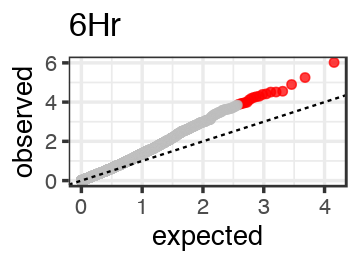

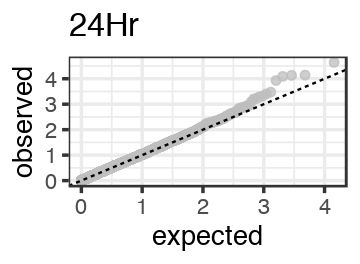

In [188]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table$FDR < 0.05)) + ggtitle("6Hr")
ggplot.qq(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table$FDR < 0.05)) + ggtitle("24Hr")

And a volcano plot:

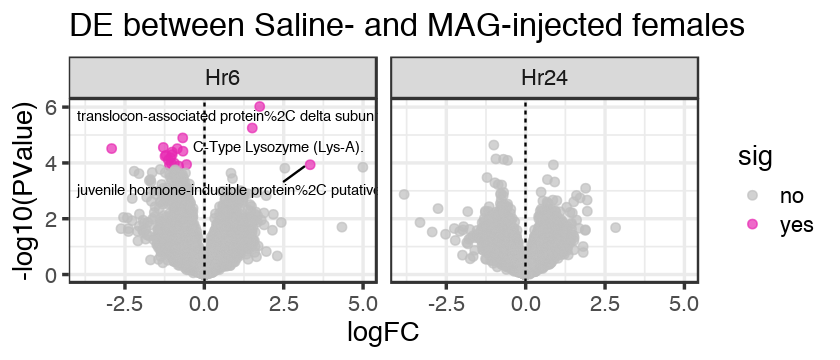

In [197]:
Al_Ftest.MAG.vs.Saline.tTags.table = rbind(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table, Al_Ftest.Hr24.MAG.vs.Saline.tTags.table)
Al_Ftest.MAG.vs.Saline.tTags.table$comparison = "MAG.vs.Saline"
Al_Ftest.MAG.vs.Saline.tTags.table$time = factor(Al_Ftest.MAG.vs.Saline.tTags.table$time, levels = c("Hr6", "Hr24"))

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Al_Ftest.MAG.vs.Saline.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time) +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#e728b2")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black") +
    geom_text_repel(data = subset(Al_Ftest.MAG.vs.Saline.tTags.table, time == "Hr6" & sig == "yes" & logFC > 0), aes(logFC, -log10(PValue),label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    ggtitle("DE between Saline- and MAG-injected females")
ggsave("Results/Figures/Al_MAG.vs.Al_Saline_VolcanoPlots.pdf", width = 7, height = 3)

Let's run a GO analysis on the set of DE genes at 24hr after injection in this comparison:

In [198]:
Al_MAG.vs.Saline.Hr6.up = subset(Al_Ftest.MAG.vs.Saline.tTags.table, sig == "yes" & time == "Hr6" & logFC > 0)$GeneID
Al_MAG.vs.Saline.Hr6.down = subset(Al_Ftest.MAG.vs.Saline.tTags.table, sig == "yes" & time == "Hr6" & logFC < 0)$GeneID

No categories are enriched in the genes that higher expression in MAG-injected fRTs. Look at those with lower expression in the MAG-injected fRTs:

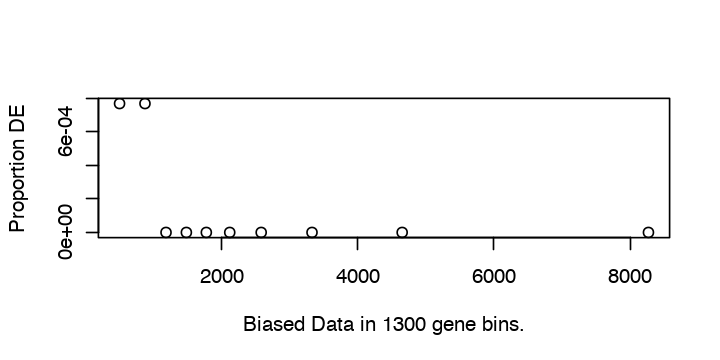

In [199]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)
cat_genes_vec = as.integer(features_with_GO %in% Al_MAG.vs.Saline.Hr6.up)
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

In [200]:
cat_genes_vec = as.integer(features_with_GO %in% Al_MAG.vs.Saline.Hr6.up)
pwf$DEgenes = cat_genes_vec
res = goseq(pwf,gene2cat=GO_info_listed)
## over-represented categories:
pvals = res$over_represented_pvalue
pvals[pvals > 1 -1e-10] = 1-1e-10
q = qvalue(pvals)
res$over_represented_FDR = q$qvalues
enrich_result_table = res[res$over_represented_pvalue<=0.05,]
descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
enrich_result_table$go_term = descr
subset(enrich_result_table, over_represented_FDR < 0.05)
# write.table(enrich_result_table, file = "Results/Tables/Al_GO_results_MAG.vs.Saline.Hr6.SalineUp.txt", quote = F, sep = "\t")

Using manually entered categories.

Calculating the p-values...

'select()' returned 1:1 mapping between keys and columns



category,over_represented_pvalue,under_represented_pvalue,numDEInCat,numInCat,term,ontology,over_represented_FDR,go_term
<chr>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>


Let's output a PDF of all the genes that are DE between MAG- and Saline-injected females

In [203]:
Al_mag.v.saline.MAGup6 = suppressMessages(lapply(Al_MAG.vs.Saline.Hr6.up, genePointPlot_Amaro, tpmTable = filter(Amaro.geneTPM.table, source == "albopictus")))
ggsave("Results/Figures/Al_mag.v.saline.MAGup6.pdf", marrangeGrob(grobs = Al_mag.v.saline.MAGup6, nrow = 2, ncol =1))

Saving 7 x 7 in image



In [204]:
Al_mag.v.saline.Salineup6 = suppressMessages(lapply(Al_MAG.vs.Saline.Hr6.down, genePointPlot_Amaro, tpmTable = filter(Amaro.geneTPM.table, source == "albopictus")))
ggsave("Results/Figures/Al_mag.v.saline.Salineup6.pdf", marrangeGrob(grobs = Al_mag.v.saline.Salineup6, nrow = 2, ncol =1))

Saving 7 x 7 in image



#### For MAG vs. none:

In [207]:
Al_Ftest.Hr6.MAG.vs.none <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_MAG.vs.Al_none[,"Hr6"])
Al_Ftest.Hr6.MAG.vs.none.tTags <- topTags(Al_Ftest.Hr6.MAG.vs.none, n = NULL)
Al_Ftest.Hr6.MAG.vs.none.tTags.table <- Al_Ftest.Hr6.MAG.vs.none.tTags$table
Al_Ftest.Hr6.MAG.vs.none.tTags.table$sig = ifelse(Al_Ftest.Hr6.MAG.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr6.MAG.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr6.MAG.vs.none.tTags.table$logFC < -1), "yes", "no")
Al_Ftest.Hr6.MAG.vs.none.tTags.table$time = "Hr6"
nrow(subset(Al_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes"))

[1] 169

In [208]:
Al_Ftest.Hr24.MAG.vs.none <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_MAG.vs.Al_none[,"Hr24"])
Al_Ftest.Hr24.MAG.vs.none.tTags <- topTags(Al_Ftest.Hr24.MAG.vs.none, n = NULL)
Al_Ftest.Hr24.MAG.vs.none.tTags.table <- Al_Ftest.Hr24.MAG.vs.none.tTags$table
Al_Ftest.Hr24.MAG.vs.none.tTags.table$sig = ifelse(Al_Ftest.Hr24.MAG.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr24.MAG.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr24.MAG.vs.none.tTags.table$logFC < -1), "yes", "no")
Al_Ftest.Hr24.MAG.vs.none.tTags.table$time = "Hr24"
nrow(subset(Al_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes"))

[1] 103

Output tables:

In [213]:
tmp6_Al <- subset(Al_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes")
tmp6_Al$direction <- ifelse(tmp6_Al$logFC > 0, "up-regulated", "down-regulated")
tmp24_Al <- subset(Al_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes")
tmp24_Al$direction <- ifelse(tmp24_Al$logFC > 0, "up-regulated", "down-regulated")
Al_MAG.vs.none_DE_genes <- rbind(tmp6_Al, tmp24_Al)
write.table(Al_MAG.vs.none_DE_genes, "Results/Tables/Al_MAG.vs.Al_none_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Al, tmp24_Al)

Check the qq-plot for this contrast:

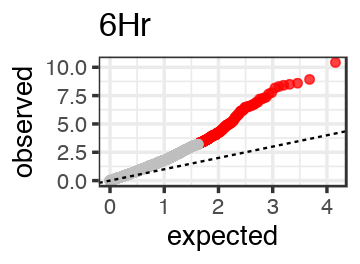

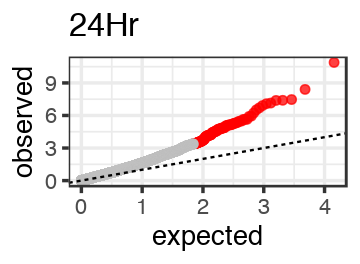

In [209]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Al_Ftest.Hr6.MAG.vs.none.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr6.MAG.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr6.MAG.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr6.MAG.vs.none.tTags.table$logFC < -1))) + ggtitle("6Hr")
ggplot.qq(Al_Ftest.Hr24.MAG.vs.none.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr24.MAG.vs.none.tTags.table$FDR < 0.05& (Al_Ftest.Hr24.MAG.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr24.MAG.vs.none.tTags.table$logFC < -1))) + ggtitle("24Hr")

And a volcano plot:

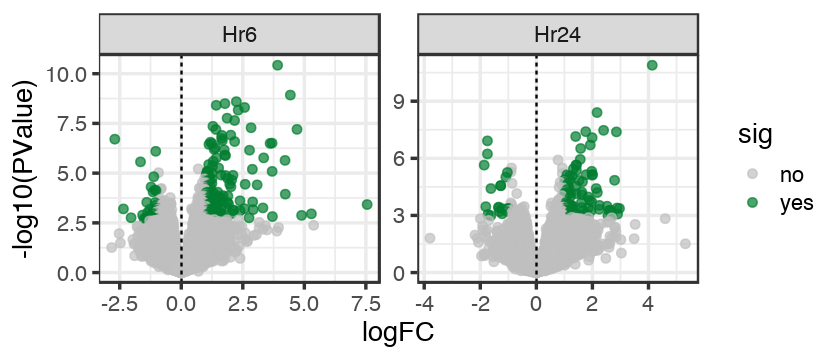

In [215]:
Al_Ftest.MAG.vs.none.tTags.table = rbind(Al_Ftest.Hr6.MAG.vs.none.tTags.table, Al_Ftest.Hr24.MAG.vs.none.tTags.table)
Al_Ftest.MAG.vs.none.tTags.table$comparison = "MAG.vs.none"
Al_Ftest.MAG.vs.none.tTags.table$time = factor(Al_Ftest.MAG.vs.none.tTags.table$time, levels = c("Hr6", "Hr24"))

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Al_Ftest.MAG.vs.none.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time, scales = "free") +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#007d30")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black")
ggsave("Results/Figures/Al_MAG.vs.none_VolcanoPlots.pdf", width = 5, height = 3)

#### For Saline vs. none:

In [216]:
Al_Ftest.Hr6.Saline.vs.none <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_saline.vs.Al_none[,"Hr6"])
Al_Ftest.Hr6.Saline.vs.none.tTags <- topTags(Al_Ftest.Hr6.Saline.vs.none, n = NULL)
Al_Ftest.Hr6.Saline.vs.none.tTags.table <- Al_Ftest.Hr6.Saline.vs.none.tTags$table
Al_Ftest.Hr6.Saline.vs.none.tTags.table$sig = ifelse(Al_Ftest.Hr6.Saline.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr6.Saline.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr6.Saline.vs.none.tTags.table$logFC < -1), "yes", "no")
Al_Ftest.Hr6.Saline.vs.none.tTags.table$time = "Hr6"
nrow(subset(Al_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes"))

[1] 134

In [217]:
Al_Ftest.Hr24.Saline.vs.none <- glmQLFTest(dgeList_Amaro_Al_sample_fit, contrast = Al_saline.vs.Al_none[,"Hr24"])
Al_Ftest.Hr24.Saline.vs.none.tTags <- topTags(Al_Ftest.Hr24.Saline.vs.none, n = NULL)
Al_Ftest.Hr24.Saline.vs.none.tTags.table <- Al_Ftest.Hr24.Saline.vs.none.tTags$table
Al_Ftest.Hr24.Saline.vs.none.tTags.table$sig = ifelse(Al_Ftest.Hr24.Saline.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr24.Saline.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr24.Saline.vs.none.tTags.table$logFC < -1), "yes", "no")
Al_Ftest.Hr24.Saline.vs.none.tTags.table$time = "Hr24"
nrow(subset(Al_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes"))

[1] 227

Output tables:

In [219]:
tmp6_Al <- subset(Al_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes")
tmp6_Al$direction <- ifelse(tmp6_Al$logFC > 0, "up-regulated", "down-regulated")
tmp24_Al <- subset(Al_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes")
tmp24_Al$direction <- ifelse(tmp24_Al$logFC > 0, "up-regulated", "down-regulated")
Al_Saline.vs.none_DE_genes <- rbind(tmp6_Al, tmp24_Al)
write.table(Al_Saline.vs.none_DE_genes, "Results/Tables/Al_Saline.vs.Al_none_DE_genes.txt", quote = F, row.names = F, sep = "\t")
rm(tmp6_Al, tmp24_Al)

Check the qq-plot for this contrast:

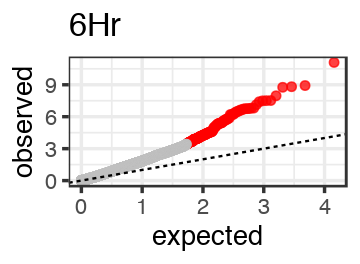

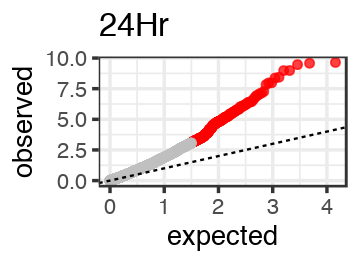

In [218]:
options(repr.plot.width = 3, repr.plot.height = 2.2)
ggplot.qq(Al_Ftest.Hr6.Saline.vs.none.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr6.Saline.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr6.Saline.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr6.Saline.vs.none.tTags.table$logFC < -1))) + ggtitle("6Hr")
ggplot.qq(Al_Ftest.Hr24.Saline.vs.none.tTags.table$PValue, hit.idx = which(Al_Ftest.Hr24.Saline.vs.none.tTags.table$FDR < 0.05 & (Al_Ftest.Hr24.Saline.vs.none.tTags.table$logFC > 1 | Al_Ftest.Hr24.Saline.vs.none.tTags.table$logFC < -1))) + ggtitle("24Hr")

And a volcano plot:

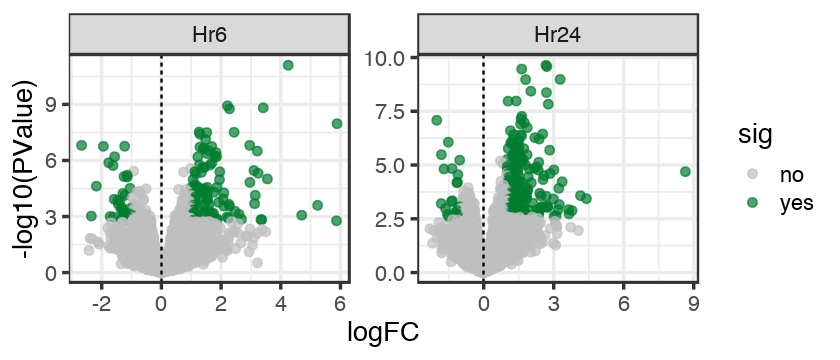

In [222]:
Al_Ftest.Saline.vs.none.tTags.table = rbind(Al_Ftest.Hr6.Saline.vs.none.tTags.table, Al_Ftest.Hr24.Saline.vs.none.tTags.table)
Al_Ftest.Saline.vs.none.tTags.table$comparison = "Saline.vs.none"
Al_Ftest.Saline.vs.none.tTags.table$time = factor(Al_Ftest.Saline.vs.none.tTags.table$time, levels = c("Hr6", "Hr24"))

options(repr.plot.width = 7, repr.plot.height = 3)
ggplot(Al_Ftest.Saline.vs.none.tTags.table, aes(logFC, -log10(PValue), colour = sig)) + 
    geom_point(alpha = 0.7, size = 2) + 
    facet_wrap(~time, scales = "free") +
#     theme_monokai_full() + 
    scale_colour_manual(values = c("grey", "#007d30")) + 
    geom_vline(xintercept = 0, linetype = "dashed", colour = "black")
ggsave("Results/Figures/Al_Saline.vs.Al_none_VolcanoPlots.pdf", width = 7, height = 3)

Look at the overlap between DE genes at 6hpi from this study DE genes at 6hpm from the Alfona study:

                   Length Class  Mode     
MAG                 92    -none- character
Saline              58    -none- character
Alfonso            220    -none- character
MAG,Saline          69    -none- character
MAG,Alfonso          4    -none- character
Saline,Alfonso       3    -none- character
MAG,Saline,Alfonso   4    -none- character

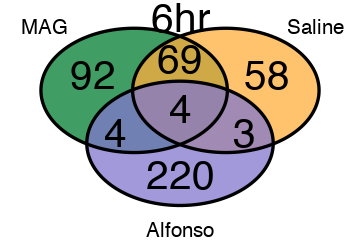

In [223]:
Al_Hr6Overlap_candidates <- list(MAG = subset(Al_Ftest.Hr6.MAG.vs.none.tTags.table, sig == "yes")$GeneID, 
                        Saline = subset(Al_Ftest.Hr6.Saline.vs.none.tTags.table, sig == "yes")$GeneID,
                          Alfonso = c(Alfonso_6hpm_v_virgin_sigGene_down, Alfonso_6hpm_v_virgin_sigGene_up))

Al_Hr6Overlap_Vdiag<-venn.diagram(Al_Hr6Overlap_candidates, NULL, fill=c("#007d30", "#ffad3d", "#8277cc"), alpha=c(0.75,0.75,0.75), cex = 2, cat.fontface= 6, cat.cex = 1, resolution = 100, main = "6hr", main.cex = 2, cat.dist = c(0.1, 0.1, 0.1), main.dist = -0.9)

Al_Hr6Overlap_combs <- unlist(lapply(1:length(Al_Hr6Overlap_candidates), function(j) combn(names(Al_Hr6Overlap_candidates), j, simplify = FALSE)), recursive = FALSE)
names(Al_Hr6Overlap_combs) <- sapply(Al_Hr6Overlap_combs, function(i) paste0(i, collapse = ","))
Al_Hr6Overlap_elements <- lapply(Al_Hr6Overlap_combs, function(i) Setdiff(Al_Hr6Overlap_candidates[i], Al_Hr6Overlap_candidates[setdiff(names(Al_Hr6Overlap_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=Al_Hr6Overlap_Vdiag))
summary(Al_Hr6Overlap_elements)
rm(Al_Hr6Overlap_candidates, Al_Hr6Overlap_Vdiag, Al_Hr6Overlap_combs)

Look at the overlap between DE genes at 24hpi from this study DE genes at 6hpm from the Alfona study:

                   Length Class  Mode     
MAG                 27    -none- character
Saline             142    -none- character
Alfonso            336    -none- character
MAG,Saline          67    -none- character
MAG,Alfonso          1    -none- character
Saline,Alfonso      10    -none- character
MAG,Saline,Alfonso   8    -none- character

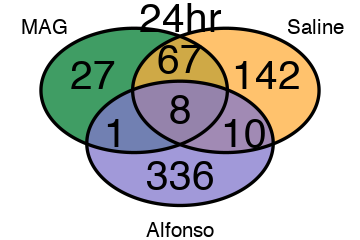

In [224]:
Al_Hr24Overlap_candidates <- list(MAG = subset(Al_Ftest.Hr24.MAG.vs.none.tTags.table, sig == "yes")$GeneID, 
                        Saline = subset(Al_Ftest.Hr24.Saline.vs.none.tTags.table, sig == "yes")$GeneID,
                          Alfonso = c(Alfonso_24hpm_v_virgin_sigGene_down, Alfonso_24hpm_v_virgin_sigGene_up))

Al_Hr24Overlap_Vdiag<-venn.diagram(Al_Hr24Overlap_candidates, NULL, fill=c("#007d30", "#ffad3d", "#8277cc"), alpha=c(0.75,0.75,0.75), cex = 2, cat.fontface= 24, cat.cex = 1, resolution = 100, main = "24hr", main.cex = 2, cat.dist = c(0.1, 0.1, 0.1), main.dist = -0.9)

Al_Hr24Overlap_combs <- unlist(lapply(1:length(Al_Hr24Overlap_candidates), function(j) combn(names(Al_Hr24Overlap_candidates), j, simplify = FALSE)), recursive = FALSE)
names(Al_Hr24Overlap_combs) <- sapply(Al_Hr24Overlap_combs, function(i) paste0(i, collapse = ","))
Al_Hr24Overlap_elements <- lapply(Al_Hr24Overlap_combs, function(i) Setdiff(Al_Hr24Overlap_candidates[i], Al_Hr24Overlap_candidates[setdiff(names(Al_Hr24Overlap_candidates), i)]))

options(repr.plot.width = 3, repr.plot.height =2)
grid.arrange(gTree(children=Al_Hr24Overlap_Vdiag))
summary(Al_Hr24Overlap_elements)
rm(Al_Hr24Overlap_candidates, Al_Hr24Overlap_Vdiag, Al_Hr24Overlap_combs)

Let's plot the log fold change between the two studies (MAG injection and post-mating)

In [231]:
tmpAmaro6hpi = select(Al_Ftest.Hr6.MAG.vs.none.tTags.table, GeneID, Am_logFC = logFC, Am_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAlfonso6hpi = select(Ftest.hpm6.v.virgin.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
tmp6hr = merge(tmpAmaro6hpi, tmpAlfonso6hpi, by.x = "GeneID", by.y = "GeneID", all = T)
tmp6hr$time = "Hr6"
tmpAmaro24hpi = select(Al_Ftest.Hr24.MAG.vs.none.tTags.table, GeneID, Am_logFC = logFC, Am_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAlfonso24hpi = select(Ftest.hpm24.v.virgin.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
tmp24hr = merge(tmpAmaro24hpi, tmpAlfonso24hpi, by.x = "GeneID", by.y = "GeneID", all = T)
tmp24hr$time = "Hr24"
tmpDF = rbind(tmp6hr, tmp24hr)
Al_Alfonso_Amaro_logFC_comparison <- filter(tmpDF, Am_sig == "yes" | Al_sig == "sig")
write.table(Al_Alfonso_Amaro_logFC_comparison, "Results/Tables/Al_Alfonso_Amaro_logFC_comparison.txt", quote = F, row.names = F, sep = "\t")

Warning message:
"Removed 2131 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 76 rows containing missing values (geom_point)."
Warning message:
"Removed 3 rows containing missing values (geom_text_repel)."


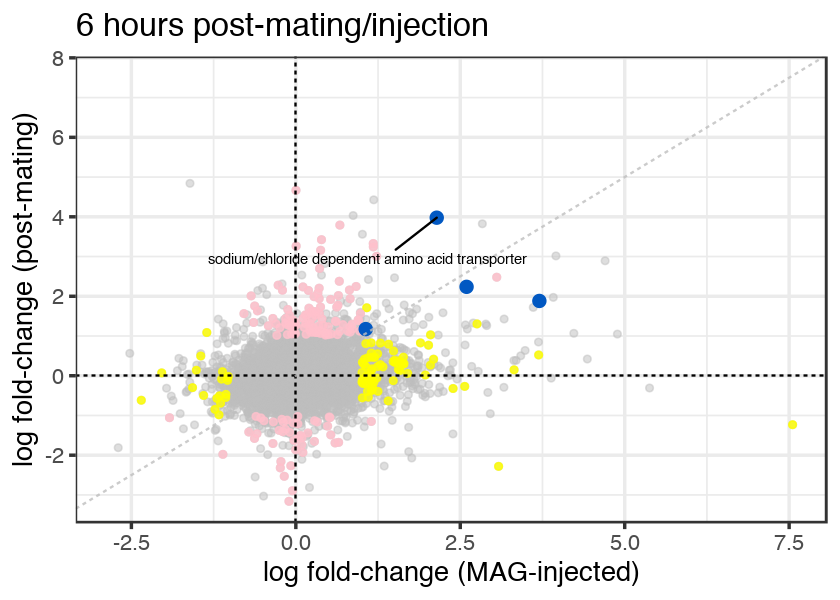

In [232]:
options(repr.plot.width = 7, repr.plot.height =5)
ggplot() +
    geom_point(data = subset(tmp6hr, GeneID %!in% Al_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "gray", alpha = 0.5) +
    geom_point(data = subset(tmp6hr, GeneID %in% Al_Hr6Overlap_elements$MAG), aes(Am_logFC, Al_logFC), colour = "yellow", alpha = 0.8) +
    geom_point(data = subset(tmp6hr, GeneID %in% Al_Hr6Overlap_elements$Alfonso), aes(Am_logFC, Al_logFC), colour = "pink", alpha = 0.8) +
    geom_point(data = subset(tmp6hr, GeneID %in% Al_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "#0158c2", size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_text_repel(data = subset(tmp6hr, GeneID %in% Al_Hr6Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC,label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(x = "log fold-change (MAG-injected)", y = "log fold-change (post-mating)") +
    ggtitle("6 hours post-mating/injection") +
    scale_y_continuous(limits = c(NA, 7.5))
# ggsave("Results/Figures/Al_Hr6.LogFC_comparison_injection.vs.mating.pdf", width = 7, height = 5)

Warning message:
"Removed 2130 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 97 rows containing missing values (geom_point)."
Warning message:
"Removed 2130 rows containing missing values (geom_point)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."
Warning message:
"Removed 97 rows containing missing values (geom_point)."


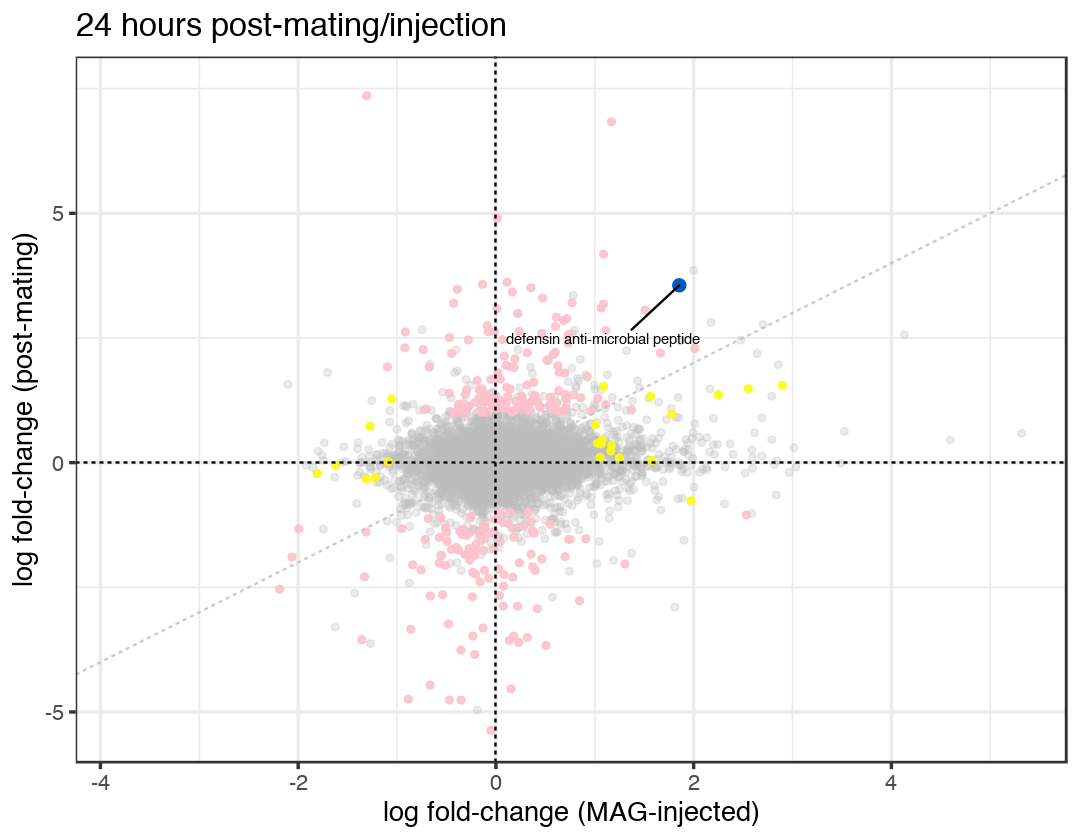

In [235]:
options(repr.plot.width = 9, repr.plot.height =7)
ggplot() +
    geom_point(data = subset(tmp24hr, GeneID %!in% Al_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "gray", alpha = 0.3) +
    geom_point(data = subset(tmp24hr, GeneID %in% Al_Hr24Overlap_elements$MAG), aes(Am_logFC, Al_logFC), colour = "yellow", alpha = 0.8) +
    geom_point(data = subset(tmp24hr, GeneID %in% Al_Hr24Overlap_elements$Alfonso), aes(Am_logFC, Al_logFC), colour = "pink", alpha = 0.8) +
    geom_point(data = subset(tmp24hr, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC > 0), aes(Am_logFC, Al_logFC), colour = "#0158c2", size = 3) +
    geom_point(data = subset(tmp24hr, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC < 0), aes(Am_logFC, Al_logFC), colour = "#ff6659", size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_text_repel(data = subset(tmp24hr, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC,label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(x = "log fold-change (MAG-injected)", y = "log fold-change (post-mating)") +
    ggtitle("24 hours post-mating/injection") +
    scale_y_continuous(limits = c(NA, 7.5))
ggsave("Results/Figures/Al_Hr24.LogFC_comparison_injection.vs.mating.pdf", width = 9, height = 7)

Let's compare the aegypti and albopictus injected data:

In [239]:
tmpAe6hpi = select(Ae_Ftest.Hr6.MAG.vs.Saline.tTags.table, GeneID, Ae_logFC = logFC, Ae_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAl6hpi = select(Al_Ftest.Hr6.MAG.vs.Saline.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
MAG_6hr = merge(tmpAe6hpi, tmpAl6hpi, by.x = "GeneID", by.y = "GeneID", all = T)
MAG_6hr$time = "Hr6"

tmpAe24hpi = select(Ae_Ftest.Hr24.MAG.vs.Saline.tTags.table, GeneID, Ae_logFC = logFC, Ae_sig = sig, VectorBase_description, SwissProt_BlastX_Description)
tmpAl24hpi = select(Al_Ftest.Hr24.MAG.vs.Saline.tTags.table, GeneID, Al_logFC = logFC, Al_sig = sig)
MAG_24hr = merge(tmpAe24hpi, tmpAl24hpi, by.x = "GeneID", by.y = "GeneID", all = T)
MAG_24hr$time = "Hr24"

Ae_Al_MAG.v.Saline_LogFC <- rbind(MAG_6hr, MAG_24hr)

In [240]:
head(Ae_Al_MAG.v.Saline_LogFC)

,GeneID,Ae_logFC,Ae_sig,VectorBase_description,SwissProt_BlastX_Description,Al_logFC,Al_sig,time
,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
1,AAEL000001,0.3341074,no,NA,Bystin,0.305730889,no,Hr6
2,AAEL000005,-0.4638975,no,NA,Zinc finger protein ZFMSA12A,0.370765662,no,Hr6
3,AAEL000006,0.1004577,no,phosphoenolpyruvate carboxykinase,Phosphoenolpyruvate carboxykinase [GTP],1.289666631,no,Hr6
4,AAEL000008,-0.2930818,no,WD and tetratricopeptide repeat protein,WD and tetratricopeptide repeats protein 1,-0.004875073,no,Hr6
5,AAEL000010,0.1310675,no,60S ribosomal protein L36,60S ribosomal protein L36,0.168474203,no,Hr6
6,AAEL000013,-0.4843155,no,peptidyl-prolyl cis-trans isomerase (cyclophilin),Peptidyl-prolyl cis-trans isomerase D,0.143141141,no,Hr6


In [ ]:
options(repr.plot.width = 9, repr.plot.height =7)
ggplot() +
    geom_point(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %!in% Al_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC), colour = "gray", alpha = 0.3) +
    geom_point(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %in% Al_Hr24Overlap_elements$MAG), aes(Am_logFC, Al_logFC), colour = "yellow", alpha = 0.8) +
    geom_point(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %in% Al_Hr24Overlap_elements$Alfonso), aes(Am_logFC, Al_logFC), colour = "pink", alpha = 0.8) +
    geom_point(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC > 0), aes(Am_logFC, Al_logFC), colour = "#0158c2", size = 3) +
    geom_point(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso` & Am_logFC < 0), aes(Am_logFC, Al_logFC), colour = "#ff6659", size = 3) +
    geom_vline(xintercept = 0, linetype = "dashed") +
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_abline(intercept = 0, slope = 1, linetype = "dashed", colour = "gray", alpha = 0.8) +
    geom_text_repel(data = subset(Ae_Al_MAG.v.Saline_LogFC, GeneID %in% Al_Hr24Overlap_elements$`MAG,Alfonso`), aes(Am_logFC, Al_logFC,label=VectorBase_description), 
                    force = 50, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
#                     point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 3) +
    labs(x = "log fold-change (MAG-injected)", y = "log fold-change (post-mating)") +
    ggtitle("24 hours post-mating/injection") +
    scale_y_continuous(limits = c(NA, 7.5))